### Библиотеки

In [29]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from chronos import BaseChronosPipeline
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from torch.nn import Module
from tqdm.notebook import tqdm

import tsururu.dataset
from tsururu.model_training.trainer import DLTrainer, MLTrainer
from tsururu.model_training.validator import KFoldCrossValidator, HoldOutValidator
from tsururu.models.boost import CatBoost, CatBoostRegressor
from tsururu.strategies import MIMOStrategy

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer

import statsforecast as stf
import statsforecast.models as stfm
from statsforecast import StatsForecast

import utilsforecast
import utilsforecast.losses
from utilsforecast.losses import mae, rmse, smape, mase, mape
from utilsforecast.evaluation import evaluate

import ta

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import EfficientFCParameters

import holidays

import optuna
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from catboost import CatBoostRegressor
from mlforecast import MLForecast
import pandas as pd
from tqdm import tqdm
import utilsforecast.losses
import catboost

from sklearn.ensemble import RandomForestRegressor

from neuralforecast import NeuralForecast
from neuralforecast.models import RNN
from neuralforecast.losses.pytorch import MQLoss, MASE
from neuralforecast.models import SOFTS
from neuralforecast.models import TimesNet
from neuralforecast.models import StemGNN

import sqlite3

import torch
from torch.optim import AdamW
import numpy as np
import pandas as pd
from chronos import BaseChronosPipeline
import os

warnings.filterwarnings("ignore")

### Читаем данные

In [5]:
with sqlite3.connect('moex_stock_price_prediction_service.db') as conn:
    df = pd.read_sql('SELECT * FROM clean_prices', conn,
                     parse_dates={"TRADEDATE": {"format": "%Y-%m-%d"}})


### Визуализация

In [6]:
cols_dct = {
    'CLOSE': 'Цены закрытия',
    # 'OPEN': 'Цены открытия',
    # 'WAPRICE': 'Средневзвешенная цена',
    # 'LOW': 'Минимальная цена',
    # 'HIGH': 'Максимальная цена',
    # 'VOLUME': 'Объем торгов',
}

for col_name, description in cols_dct.items():

    fig = px.line(
        df, 
        x='TRADEDATE', 
        y=col_name, 
        color='SECID', 
        title=description,
        labels={col_name: 'Значение', 'TRADEDATE': 'Дата', 'id': 'Категория'}
    )

    fig.update_layout(
        hovermode='x unified',
        legend_title_text='Номер ряда',
        xaxis_title='Дата',
        yaxis_title='Значение',
        template='plotly_white' 
    )

    fig.show()

### Выделение тренировочной, валидационной и тестовой выборок

Выделим на валидацию 14 дней, 1 день для тестирования финальной модели, остальное - трейн

In [7]:
TEST_DATASET_SIZE = 1
VAL_DATASET_SIZE = 14
TRAIN_DATASET_SIZE = df['TRADEDATE'].nunique() - TEST_DATASET_SIZE - VAL_DATASET_SIZE

### Бейзлайны

Попробуем различные статистические бейзлайны

**Будем подбирать бейзлайн следующим методом:**
- Выделяем валидационную выборку (14 дней)
- Обучаемся на всей информации, хотим прогнозировать значение цены на 1 шаг вперед
- Прогнозируем цену первого дня валидации, считаем метрики качества прогнозирования (MASE, MAPE, SMAPE)

- На следующем шаге в тренировочную выборку добавляем день из валидации и прогнозируем второй день валидации, так же считаем метрики

- Повторяем пока валидационная выборка не закончится

- Усредняем полученные метрики за VAL_SIZE дней

- Выбираем бейзлайн

In [8]:
# Выделяем без теста, чтобы не заглядывать
grouped_row_number = df.groupby('SECID').cumcount()

df_for_naive = df.loc[grouped_row_number < TRAIN_DATASET_SIZE + VAL_DATASET_SIZE, ['TRADEDATE', 'SECID', 'CLOSE']]

df_for_naive = df_for_naive.rename(columns={
    'TRADEDATE': 'ds',
    'SECID': 'unique_id',
    'CLOSE': 'y'
})

#### Прогноз на 1 день вперед

In [269]:
# Функция для подсчета метрики доли верных угадываний движения цены

def directional_accuracy(df_train, forecast, model_names, target_col='y', id_col='unique_id', date_col='ds'):
    last_train_target = df_train[df_train[date_col] == df_train[date_col].max()].reset_index(drop=True)[target_col]
    
    forecast_diffs = ((forecast[model_names] - np.array(last_train_target).reshape(-1, 1)) >= 0).astype(int)
    
    true_false_matrix = (forecast_diffs == np.array(forecast_diffs[target_col]).reshape(-1, 1)).astype(int)

    return true_false_matrix.set_index(forecast[id_col]).reset_index()

In [10]:
max_date_num_val = TRAIN_DATASET_SIZE + VAL_DATASET_SIZE

# Определяем размер валидационной выборки
VALIDATION_SIZE = 14
TEST_SIZE = 1  # прогноз на 1 шаг вперед

# Подготовка для хранения результатов всех 7 прогнозов
all_metrics = []

naive_forecasts = []

for val_day in tqdm(range(VALIDATION_SIZE)):
    # Определяем маски для текущего прогноза
    # Конец обучающей выборки сдвигается с каждой итерацией
    train_end = max_date_num_val - VALIDATION_SIZE + val_day
    
    train_mask = grouped_row_number < train_end
    test_mask = grouped_row_number == train_end  # только 1 день для тестирования
    
    # Датасеты для наивных прогнозов
    df_train_naive_current = df_for_naive[train_mask]
    df_test_naive_current = df_for_naive[test_mask]
    
    # Инициализируем модели для каждого прогноза
    models = [
        stfm.Naive(),
        stfm.AutoARIMA(),
        stfm.AutoCES(),
        stfm.AutoETS(),
        stfm.AutoRegressive(lags=list(range(1, 8))),
        stfm.RandomWalkWithDrift(),
        stfm.WindowAverage(window_size=2, alias='WindowAverage(2)'),
        stfm.WindowAverage(window_size=3, alias='WindowAverage(3)'),
        stfm.WindowAverage(window_size=4, alias='WindowAverage(4)'),
        stfm.WindowAverage(window_size=5, alias='WindowAverage(5)'),
        stfm.WindowAverage(window_size=6, alias='WindowAverage(6)'),
        stfm.WindowAverage(window_size=7, alias='WindowAverage(7)'),
        stfm.WindowAverage(window_size=14, alias='WindowAverage(14)'),
    ]
    
    sf = StatsForecast(
        models=models,
        freq='D'
    )
    
    # Делаем прогнозы на 1 шаг вперед
    forecast_current = sf.forecast(df=df_train_naive_current, h=TEST_SIZE)
    
    # Добавляем фактические значения
    forecast_current['y'] = df_test_naive_current['y'].reset_index(drop=True)
    forecast_current.loc[:, 'ds'] = df_test_naive_current['ds'].reset_index(drop=True)

    naive_forecasts.append(forecast_current)

    # Извлекаем имена моделей
    model_names = forecast_current.columns[2:]
    
    # Рассчитываем метрики для текущего прогноза
    mase_current = utilsforecast.losses.mase(
        df=forecast_current, 
        train_df=df_train_naive_current,
        models=model_names,
        seasonality=1,
    )
    
    mape_current = utilsforecast.losses.mape(
        df=forecast_current, 
        models=model_names,
    )
    
    smape_current = utilsforecast.losses.smape(
        df=forecast_current, 
        models=model_names,
    )

    directional_accuracy_current = directional_accuracy(
        df_train_naive_current, forecast_current, model_names
    )
    
    # Сохраняем метрики для текущего дня валидации
    day_metrics = pd.DataFrame(data={
        'MASE_mean': mase_current.iloc[:, 1:].mean(),
        'MAPE_mean': mape_current.iloc[:, 1:].mean(),
        'SMAPE_mean': smape_current.iloc[:, 1:].mean(),
        'Directional_Accuracy_mean': directional_accuracy_current.iloc[:, 1:].mean(),

        'MASE_median': mase_current.iloc[:, 1:].median(),
        'MAPE_median': mape_current.iloc[:, 1:].median(),
        'SMAPE_median': smape_current.iloc[:, 1:].median(),
        'Directional_Accuracy_median': directional_accuracy_current.iloc[:, 1:].median()
    })
    
    # Добавляем информацию о дне валидации
    day_metrics['validation_day'] = val_day + 1
    
    # Добавляем в общий список
    all_metrics.append(day_metrics)

# Объединяем все метрики
combined_metrics = pd.concat(all_metrics)

# Группируем и усредняем по моделям
avg_metrics = combined_metrics.groupby(combined_metrics.index).mean().drop('validation_day', axis=1)

# Сортируем по MASE
final_metrics = avg_metrics.sort_values(by='MASE_median')

# Выводим финальные усредненные метрики
final_metrics

100%|██████████| 14/14 [02:37<00:00, 11.25s/it]


MASE_mean  MAPE_mean  SMAPE_mean  \
y                   0.000000   0.000000    0.000000   
AutoARIMA           0.887251   0.014194    0.007080   
RWD                 0.882467   0.014074    0.007019   
Naive               0.883129   0.014119    0.007039   
AutoETS             0.885894   0.014173    0.007068   
CES                 0.908864   0.014511    0.007233   
AutoRegressive      0.917551   0.014782    0.007369   
WindowAverage(2)    1.049940   0.016748    0.008339   
WindowAverage(3)    1.183505   0.019035    0.009462   
WindowAverage(4)    1.284377   0.020791    0.010321   
WindowAverage(5)    1.364199   0.022275    0.011035   
WindowAverage(6)    1.424808   0.023368    0.011545   
WindowAverage(7)    1.468713   0.024129    0.011889   
WindowAverage(14)   1.713490   0.028568    0.013994   

                   Directional_Accuracy_mean  MASE_median  MAPE_median  \
y                                   1.000000     0.000000     0.000000   
AutoARIMA                           0.443182     0.707527     0.012067   
RWD                                 0.509740     0.707623     0.011901   
Naive                               0.426948     0.712339     0.011933   
AutoETS                             0.405844     0.714716     0.011920   
CES                                 0.485390     0.758950     0.012322   
AutoRegressive                      0.423701     0.763405     0.012482   
WindowAverage(2)                    0.428571     0.865799     0.014057   
WindowAverage(3)                    0.451299     0.997822     0.016812   
WindowAverage(4)                    0.459416     1.090919     0.018399   
WindowAverage(5)                    0.501623     1.152022     0.019888   
WindowAverage(6)                    0.524351     1.190863     0.021308   
WindowAverage(7)                    0.548701     1.235269     0.021859   
WindowAverage(14)                   0.538961     1.454360     0.026854   

                   SMAPE_median  Directional_Accuracy_median  
y                      0.000000                     1.000000  
AutoARIMA              0.006022                     0.321429  
RWD                    0.005945                     0.535714  
Naive                  0.005957                     0.392857  
AutoETS                0.005953                     0.285714  
CES                    0.006152                     0.464286  
AutoRegressive         0.006233                     0.357143  
WindowAverage(2)       0.007021                     0.392857  
WindowAverage(3)       0.008389                     0.357143  
WindowAverage(4)       0.009180                     0.428571  
WindowAverage(5)       0.009906                     0.500000  
WindowAverage(6)       0.010587                     0.500000  
WindowAverage(7)       0.010831                     0.500000  
WindowAverage(14)      0.013244                     0.535714

In [11]:
naive_forecasts_df = pd.concat(naive_forecasts)

baseline_models = final_metrics.index

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = naive_forecasts_df[naive_forecasts_df['unique_id'] == ticker]

    for model in baseline_models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model} (MASE_median: {final_metrics.loc[model, "MASE_median"] :.2f})'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

##### Выбор модели бейзлайна

Лучше всех себя показала AutoARIMA, хотя они очень похожи с RWD и Наивной моделью.

### Признаки

#### Лаговые признаки

In [12]:
lag_features = []

for lag_num in range(1, 8):
    df[f'lag{lag_num}_CLOSE'] = df.groupby('SECID')['CLOSE'].shift(lag_num)
    lag_features.append(f'lag{lag_num}_CLOSE')

display(df)

print(f'Добавлены признаки: {lag_features}')

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  lag4_CLOSE  lag5_CLOSE  \
0      59304300.0         NaN         NaN         NaN         NaN         NaN   
1      40030900.0      13.890         NaN         NaN         NaN         NaN   
2      25206000.0      14.105      13.890         NaN         NaN         NaN   
3      14170100.0      13.451      14.105      13.890         NaN         NaN   
4      15927000.0      13.493      13.451      14.105       13.89         NaN   
...           ...         ...         ...         ...         ...         ...   
35195    308142.0    4040.500    4054.000    4022.000     3989.50      4021.0   
35196    773529.0    3990.500    4040.500    4054.000     4022.00      3989.5   
35197    335528.0    4024.000    3990.500    4040.500     4054.00      4022.0   
35198    505249.0    4009.500    4024.000    3990.500     4040.50      4054.0   
35199    694981.0    3917.000    4009.500    4024.000     3990.50      4040.5   

       lag6_CLOSE  lag7_CLOSE  
0             NaN         NaN  
1             NaN         NaN  
2             NaN         NaN  
3             NaN         NaN  
4             NaN         NaN  
...           ...         ...  
35195      4114.5      4153.5  
35196      4021.0      4114.5  
35197      3989.5      4021.0  
35198      4022.0      3989.5  
35199      4054.0      4022.0  

[35200 rows x 15 columns]

Добавлены признаки: ['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE']


#### Признаки для дат

In [13]:
date_features = []

# Праздники
ru_holidays = holidays.country_holidays(
    'RU',
    years=range(2022, 2026)
)


df['weekend_flg'] = (df['TRADEDATE'].apply(lambda x: x.weekday()) >= 5).astype(int)
date_features.append('weekend_flg')

df['is_month_end'] = df['TRADEDATE'].apply(lambda x: x.is_month_end).astype(int)
date_features.append('is_month_end')

df['is_month_start'] = df['TRADEDATE'].apply(lambda x: x.is_month_start).astype(int)
date_features.append('is_month_start')

df['is_quarter_end'] = df['TRADEDATE'].apply(lambda x: x.is_quarter_end).astype(int)
date_features.append('is_quarter_end')
df['is_quarter_start'] = df['TRADEDATE'].apply(lambda x: x.is_quarter_start).astype(int)
date_features.append('is_quarter_start')


df['is_holiday_in_russia'] = df['TRADEDATE'].apply(lambda x: x.date() in ru_holidays).astype(int)
date_features.append('is_holiday_in_russia')

df['pre_holiday_in_russa'] = df['TRADEDATE'].shift(-1).isin(ru_holidays).astype(int)
date_features.append('pre_holiday_in_russa')

df['after_holiday_in_russa'] = df['TRADEDATE'].shift(1).isin(ru_holidays).astype(int)
date_features.append('after_holiday_in_russa')


df['weekday'] = df['TRADEDATE'].apply(lambda x: x.weekday())
date_features.append('weekday')

df['month'] = df['TRADEDATE'].apply(lambda x: x.month)
date_features.append('month')

df['quart'] = df['TRADEDATE'].apply(lambda x: x.quarter)
date_features.append('quart')

display(df)

print(f'Добавлены признаки: {date_features}')

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  is_month_end  is_month_start  \
0      59304300.0         NaN         NaN  ...             0               1   
1      40030900.0      13.890         NaN  ...             0               0   
2      25206000.0      14.105      13.890  ...             0               0   
3      14170100.0      13.451      14.105  ...             0               0   
4      15927000.0      13.493      13.451  ...             0               0   
...           ...         ...         ...  ...           ...             ...   
35195    308142.0    4040.500    4054.000  ...             0               0   
35196    773529.0    3990.500    4040.500  ...             0               0   
35197    335528.0    4024.000    3990.500  ...             0               0   
35198    505249.0    4009.500    4024.000  ...             0               0   
35199    694981.0    3917.000    4009.500  ...             0               0   

       is_quarter_end  is_quarter_start  is_holiday_in_russia  \
0                   0                 1                     0   
1                   0                 0                     0   
2                   0                 0                     0   
3                   0                 0                     0   
4                   0                 0                     0   
...               ...               ...                   ...   
35195               0                 0                     0   
35196               0                 0                     0   
35197               0                 0                     0   
35198               0                 0                     0   
35199               0                 0                     0   

       pre_holiday_in_russa  after_holiday_in_russa  weekday  month  quart  
0                         0                       0        4      4      2  
1                         0                       0        0      4      2  
2                         0                       0        1      4      2  
3                         0                       0        2      4      2  
4                         0                       0        3      4      2  
...                     ...                     ...      ...    ...    ...  
35195                     0                       0        2      5      2  
35196                     0                       0        3      5      2  
35197                     0                       0        4      5      2  
35198                     0                       0        0      5      2  
35199                     0                       0        1      5      2  

[35200 rows x 26 columns]

Добавлены признаки: ['weekend_flg', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_holiday_in_russia', 'pre_holiday_in_russa', 'after_holiday_in_russa', 'weekday', 'month', 'quart']


#### Признаки на основе выплаты дивидендов (to be done)

#### Признаки для технического анализа (ta)

In [14]:
tech_analysis_features = []

# Сортируем данные по тикеру и дате
df = df.sort_values(by=['SECID', 'TRADEDATE'])

# Функция для расчета всех индикаторов в группе
def calculate_ta_indicators(group):
    # RSI
    rsi_indicator = ta.momentum.RSIIndicator(close=group['CLOSE'], window=14)
    group['rsi'] = rsi_indicator.rsi()
    
    # MACD
    macd_indicator = ta.trend.MACD(
        close=group['CLOSE'], 
        window_slow=26, 
        window_fast=12, 
        window_sign=9
    )
    group['macd'] = macd_indicator.macd()
    
    # Скользящие средние
    group['moving_average_short'] = group['CLOSE'].rolling(window=20).mean()
    group['moving_average_long'] = group['CLOSE'].rolling(window=50).mean()
    
    # Полосы Боллинджера
    bollinger = ta.volatility.BollingerBands(close=group['CLOSE'], window=20, window_dev=2)
    group['bollinger_upper'] = bollinger.bollinger_hband()
    group['bollinger_lower'] = bollinger.bollinger_lband()
    
    # Стохастический осциллятор
    stoch = ta.momentum.StochasticOscillator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14, 
        smooth_window=3
    )
    group['stoch_k'] = stoch.stoch()
    group['stoch_d'] = stoch.stoch_signal()
    
    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14
    )
    group['atr'] = atr.average_true_range()
    
    # ADX
    adx = ta.trend.ADXIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14
    )
    group['adx'] = adx.adx()
    
    # Williams %R
    williams_r = ta.momentum.WilliamsRIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        lbp=14
    )
    group['williams_r'] = williams_r.williams_r()
    
    # CCI
    cci = ta.trend.CCIIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=20
    )
    group['cci'] = cci.cci()
    
    return group

# Применяем расчеты к каждой группе отдельно
df = df.groupby('SECID', group_keys=False).apply(calculate_ta_indicators)

tech_analysis_features = [
    'rsi', 'macd', 'moving_average_short', 'moving_average_long',
    'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d',
    'atr', 'adx', 'williams_r', 'cci'
]

display(df)
print(f'Добавлены признаки: {tech_analysis_features}')


TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_short  \
0      59304300.0         NaN         NaN  ...                   NaN   
1      40030900.0      13.890         NaN  ...                   NaN   
2      25206000.0      14.105      13.890  ...                   NaN   
3      14170100.0      13.451      14.105  ...                   NaN   
4      15927000.0      13.493      13.451  ...                   NaN   
...           ...         ...         ...  ...                   ...   
35195    308142.0    4040.500    4054.000  ...              4100.225   
35196    773529.0    3990.500    4040.500  ...              4083.300   
35197    335528.0    4024.000    3990.500  ...              4069.525   
35198    505249.0    4009.500    4024.000  ...              4050.725   
35199    694981.0    3917.000    4009.500  ...              4031.775   

       moving_average_long  bollinger_upper  bollinger_lower    stoch_k  \
0                      NaN              NaN              NaN        NaN   
1                      NaN              NaN              NaN        NaN   
2                      NaN              NaN              NaN        NaN   
3                      NaN              NaN              NaN        NaN   
4                      NaN              NaN              NaN        NaN   
...                    ...              ...              ...        ...   
35195              4264.83      4390.782477      3809.667523  44.458438   
35196              4254.02      4349.161317      3817.438683  55.851064   
35197              4243.63      4320.275768      3818.774232  51.994681   
35198              4232.37      4287.635843      3813.814157  26.809651   
35199              4221.68      4218.293223      3845.256777  41.044776   

         stoch_d         atr        adx  williams_r        cci  
0            NaN    0.000000   0.000000         NaN        NaN  
1            NaN    0.000000   0.000000         NaN        NaN  
2            NaN    0.000000   0.000000         NaN        NaN  
3            NaN    0.000000   0.000000         NaN        NaN  
4            NaN    0.000000   0.000000         NaN        NaN  
...          ...         ...        ...         ...        ...  
35195  44.550237  142.320502  27.381767  -55.541562 -59.682512  
35196  48.461376  143.869037  27.610998  -44.148936 -49.657297  
35197  50.768061  137.306963  27.823856  -48.005319 -41.886977  
35198  44.885132  137.356466  28.727334  -73.190349 -92.615381  
35199  39.949703  139.616718  29.742388  -58.955224 -78.458925  

[35200 rows x 38 columns]

Добавлены признаки: ['rsi', 'macd', 'moving_average_short', 'moving_average_long', 'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d', 'atr', 'adx', 'williams_r', 'cci']


##### Чистим от пропусков

In [15]:
print(df[df['SECID'] == 'AFKS'].isna().sum())
print()
print(df[df['SECID'] == 'AFLT'].isna().sum())

TRADEDATE                  0
SECID                      0
WAPRICE                    0
OPEN                       0
CLOSE                      0
LOW                        0
HIGH                       0
VOLUME                     0
lag1_CLOSE                 1
lag2_CLOSE                 2
lag3_CLOSE                 3
lag4_CLOSE                 4
lag5_CLOSE                 5
lag6_CLOSE                 6
lag7_CLOSE                 7
weekend_flg                0
is_month_end               0
is_month_start             0
is_quarter_end             0
is_quarter_start           0
is_holiday_in_russia       0
pre_holiday_in_russa       0
after_holiday_in_russa     0
weekday                    0
month                      0
quart                      0
rsi                       13
macd                      25
moving_average_short      19
moving_average_long       49
bollinger_upper           19
bollinger_lower           19
stoch_k                   13
stoch_d                   15
atr           

In [16]:
df = df.dropna()
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
49    2022-06-16  AFKS    12.601    12.510    12.695    12.441    12.748   
50    2022-06-17  AFKS    12.611    12.700    12.508    12.508    12.741   
51    2022-06-20  AFKS    12.833    12.549    12.830    12.522    13.000   
52    2022-06-21  AFKS    12.904    12.990    12.972    12.760    12.990   
53    2022-06-22  AFKS    12.767    12.975    12.900    12.620    13.071   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_short  \
49     24067400.0      12.461      12.550  ...               12.7172   
50      9084900.0      12.695      12.461  ...               12.6751   
51     35341000.0      12.508      12.695  ...               12.6786   
52     23216000.0      12.830      12.508  ...               12.7066   
53     23391800.0      12.972      12.830  ...               12.7216   
...           ...         ...         ...  ...                   ...   
35195    308142.0    4040.500    4054.000  ...             4100.2250   
35196    773529.0    3990.500    4040.500  ...             4083.3000   
35197    335528.0    4024.000    3990.500  ...             4069.5250   
35198    505249.0    4009.500    4024.000  ...             4050.7250   
35199    694981.0    3917.000    4009.500  ...             4031.7750   

       moving_average_long  bollinger_upper  bollinger_lower    stoch_k  \
49                12.76714        13.241743        12.192657  55.405405   
50                12.73950        13.118633        12.231567  38.558559   
51                12.71400        13.125847        12.231353  67.567568   
52                12.70442        13.153697        12.259503  80.360360   
53                12.69256        13.173489        12.269711  73.873874   
...                    ...              ...              ...        ...   
35195           4264.83000      4390.782477      3809.667523  44.458438   
35196           4254.02000      4349.161317      3817.438683  55.851064   
35197           4243.63000      4320.275768      3818.774232  51.994681   
35198           4232.37000      4287.635843      3813.814157  26.809651   
35199           4221.68000      4218.293223      3845.256777  41.044776   

         stoch_d         atr        adx  williams_r        cci  
49     44.024024    0.469477  14.103937  -44.594595 -27.967641  
50     42.762763    0.452586  14.087248  -61.441441 -35.663787  
51     53.843844    0.455401  14.721709  -32.432432  44.520739  
52     62.162162    0.439301  15.310852  -19.639640  83.163072  
53     73.933934    0.440136  15.312309  -26.126126  60.583060  
...          ...         ...        ...         ...        ...  
35195  44.550237  142.320502  27.381767  -55.541562 -59.682512  
35196  48.461376  143.869037  27.610998  -44.148936 -49.657297  
35197  50.768061  137.306963  27.823856  -48.005319 -41.886977  
35198  44.885132  137.356466  28.727334  -73.190349 -92.615381  
35199  39.949703  139.616718  29.742388  -58.955224 -78.458925  

[33044 rows x 38 columns]

In [17]:
df = df.sort_values(by=['SECID', 'TRADEDATE'])

grouped_row_number = df.groupby('SECID').cumcount()

max_date_num = max(grouped_row_number)

In [18]:
X = df.loc[:, ['TRADEDATE', 'SECID', 'CLOSE'] + lag_features + date_features + tech_analysis_features]
# y = df.loc[:, ['TRADEDATE', 'SECID', 'target']]

display(X)
# display(y)

TRADEDATE SECID     CLOSE  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49    2022-06-16  AFKS    12.695      12.461      12.550      12.450   
50    2022-06-17  AFKS    12.508      12.695      12.461      12.550   
51    2022-06-20  AFKS    12.830      12.508      12.695      12.461   
52    2022-06-21  AFKS    12.972      12.830      12.508      12.695   
53    2022-06-22  AFKS    12.900      12.972      12.830      12.508   
...          ...   ...       ...         ...         ...         ...   
35195 2025-05-21  YDEX  3990.500    4040.500    4054.000    4022.000   
35196 2025-05-22  YDEX  4024.000    3990.500    4040.500    4054.000   
35197 2025-05-23  YDEX  4009.500    4024.000    3990.500    4040.500   
35198 2025-05-26  YDEX  3917.000    4009.500    4024.000    3990.500   
35199 2025-05-27  YDEX  3992.500    3917.000    4009.500    4024.000   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
35195    3989.500    4021.000    4114.500    4153.500  ...   
35196    4022.000    3989.500    4021.000    4114.500  ...   
35197    4054.000    4022.000    3989.500    4021.000  ...   
35198    4040.500    4054.000    4022.000    3989.500  ...   
35199    3990.500    4040.500    4054.000    4022.000  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
35195             4100.2250           4264.83000      4390.782477   
35196             4083.3000           4254.02000      4349.161317   
35197             4069.5250           4243.63000      4320.275768   
35198             4050.7250           4232.37000      4287.635843   
35199             4031.7750           4221.68000      4218.293223   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
35195      3809.667523  44.458438  44.550237  142.320502  27.381767   
35196      3817.438683  55.851064  48.461376  143.869037  27.610998   
35197      3818.774232  51.994681  50.768061  137.306963  27.823856   
35198      3813.814157  26.809651  44.885132  137.356466  28.727334   
35199      3845.256777  41.044776  39.949703  139.616718  29.742388   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
35195  -55.541562 -59.682512  
35196  -44.148936 -49.657297  
35197  -48.005319 -41.886977  
35198  -73.190349 -92.615381  
35199  -58.955224 -78.458925  

[33044 rows x 33 columns]

In [19]:
X.columns

Index(['TRADEDATE', 'SECID', 'CLOSE', 'lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE',
       'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE', 'weekend_flg',
       'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start',
       'is_holiday_in_russia', 'pre_holiday_in_russa',
       'after_holiday_in_russa', 'weekday', 'month', 'quart', 'rsi', 'macd',
       'moving_average_short', 'moving_average_long', 'bollinger_upper',
       'bollinger_lower', 'stoch_k', 'stoch_d', 'atr', 'adx', 'williams_r',
       'cci'],
      dtype='object')

In [20]:
train_mask = grouped_row_number <= (max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE)
val_mask = ((max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE) < grouped_row_number) & (grouped_row_number <= (max_date_num - TEST_DATASET_SIZE))
test_mask = grouped_row_number > (max_date_num - TEST_DATASET_SIZE)

In [21]:
X_train = X[train_mask]
# y_train = y[train_mask]

X_val = X[val_mask]
# y_val = y[val_mask]

X_test = X[test_mask]
# y_test = y[test_mask]

### Модели

#### Pretrained. Chronos

##### Файнтюнинг Chronos

In [30]:
HORIZON = 1
CONTEXT_LENGTH = 32
EPOCHS = 10
BATCH_SIZE = 16

united_X_train_and_val = pd.concat([X_train, X_val]).sort_values(by=['SECID', 'TRADEDATE'])

# --- Нормализация по каждому ряду ---
def normalize_per_series(df, target_col='CLOSE', id_col='SECID'):
    stats = {}
    df_norm = df.copy()
    for secid, group in df.groupby(id_col):
        mean = group[target_col].mean()
        std = group[target_col].std()
        if std == 0:
            std = 1.0
        stats[secid] = (mean, std)
        idx = df_norm[id_col] == secid
        df_norm.loc[idx, target_col] = (df_norm.loc[idx, target_col] - mean) / std
    return df_norm, stats

# --- Подготовка обучающих данных ---
def create_train_data(df, target_col='CLOSE', id_col='SECID', date_col='TRADEDATE'):
    contexts = []
    targets = []
    df = df.sort_values([id_col, date_col])
    for secid, group in df.groupby(id_col):
        series = group[target_col].values.astype(float)
        for i in range(len(series) - CONTEXT_LENGTH - HORIZON + 1):
            context = series[i:i+CONTEXT_LENGTH]
            target = series[i+CONTEXT_LENGTH:i+CONTEXT_LENGTH+HORIZON]
            contexts.append(torch.tensor(context, dtype=torch.float32))
            targets.append(torch.tensor(target, dtype=torch.float32))
    if len(contexts) == 0:
        return None, None
    contexts = torch.stack(contexts)
    targets = torch.stack(targets)
    return contexts, targets

# --- Обратное преобразование ---
def denormalize(preds, secid, stats):
    mean, std = stats[secid]
    return preds * std + mean

# --- Подготовка тренировочных данных без 14-дневной валидации ---
# Предполагается, что X_val содержит 14 дней валидации
val_days = sorted(X_val['TRADEDATE'].unique())
train_data = united_X_train_and_val[
    ~united_X_train_and_val['TRADEDATE'].isin(val_days)
]

# Нормализация
train_norm, stats = normalize_per_series(train_data)

# Создаём обучающие данные
contexts, targets = create_train_data(train_norm)
assert contexts is not None, "Недостаточно данных для обучения"

# Загружаем модель
pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-bolt-small", device_map="cpu")
model = pipeline.model
model.train()

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=1e-4)

num_batches = len(contexts) // BATCH_SIZE

# Обучение модели один раз
for epoch in (range(EPOCHS)):
    print(f'Эпоха {epoch + 1}/{EPOCHS}...')
    
    total_loss = 0
    for i in tqdm(range(num_batches)):
        optimizer.zero_grad()
        batch_context = contexts[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch_target = targets[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        outputs = model(batch_context, target=batch_target)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")


# Сохраняем модель
os.makedirs("./finetuned_chronos", exist_ok=True)

torch.save(model.state_dict(), "./finetuned_chronos/model_state.pth")
print("Модель сохранена!")

Эпоха 1/10...


100%|██████████| 1936/1936 [03:38<00:00,  8.86it/s]


Epoch 1/10, Loss: 0.3444
Эпоха 2/10...


100%|██████████| 1936/1936 [03:25<00:00,  9.41it/s]


Epoch 2/10, Loss: 0.3290
Эпоха 3/10...


100%|██████████| 1936/1936 [03:16<00:00,  9.85it/s]


Epoch 3/10, Loss: 0.3209
Эпоха 4/10...


100%|██████████| 1936/1936 [03:19<00:00,  9.72it/s]


Epoch 4/10, Loss: 0.3163
Эпоха 5/10...


100%|██████████| 1936/1936 [03:17<00:00,  9.80it/s]


Epoch 5/10, Loss: 0.3108
Эпоха 6/10...


100%|██████████| 1936/1936 [03:17<00:00,  9.82it/s]


Epoch 6/10, Loss: 0.3059
Эпоха 7/10...


100%|██████████| 1936/1936 [03:17<00:00,  9.80it/s]


Epoch 7/10, Loss: 0.3000
Эпоха 8/10...


100%|██████████| 1936/1936 [03:20<00:00,  9.66it/s]


Epoch 8/10, Loss: 0.2963
Эпоха 9/10...


100%|██████████| 1936/1936 [03:18<00:00,  9.78it/s]


Epoch 9/10, Loss: 0.2885
Эпоха 10/10...


100%|██████████| 1936/1936 [03:17<00:00,  9.79it/s]


Epoch 10/10, Loss: 0.2846
Модель сохранена!


##### Инициализация zero-shot и finetuned Chronos

In [31]:
from chronos import BaseChronosPipeline
import torch

HORIZON = 1
CONTEXT_LENGTH = 32

Chronos_zero_shot = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-small",
    device_map="cpu"
)

Chronos_finetuned = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-small",
    device_map="cpu"
)
Chronos_finetuned.model.load_state_dict(torch.load("./finetuned_chronos/model_state.pth", map_location="cpu"))
Chronos_finetuned.model.eval()
Chronos_zero_shot.model.eval()

ChronosBoltModelForForecasting(
  (shared): Embedding(2, 512)
  (input_patch_embedding): ResidualBlock(
    (dropout): Dropout(p=0.1, inplace=False)
    (hidden_layer): Linear(in_features=32, out_features=2048, bias=True)
    (act): ReLU()
    (output_layer): Linear(in_features=2048, out_features=512, bias=True)
    (residual_layer): Linear(in_features=32, out_features=512, bias=True)
  )
  (patch): Patch()
  (instance_norm): InstanceNorm()
  (encoder): T5Stack(
    (embed_tokens): Embedding(2, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding

##### Валидация zero-shot и finetuned Chronos

In [44]:
def run_inference(pipeline, model_name, context_length=CONTEXT_LENGTH):
    all_preds = []
    all_true = []

    for val_day in tqdm(sorted(X_val['TRADEDATE'].unique()), desc=f"Inference {model_name}"):
        for secid in X_val['SECID'].unique():
            full_series = united_X_train_and_val[
                (united_X_train_and_val['SECID'] == secid) &
                (united_X_train_and_val['TRADEDATE'] < val_day)
            ].sort_values('TRADEDATE')['CLOSE'].values.astype(float)

            if len(full_series) < context_length:
                continue

            mean, std = stats.get(secid, (0,1))
            norm_series = (full_series - mean) / std

            context_tensor = torch.tensor(norm_series[-context_length:], dtype=torch.float32).unsqueeze(0)

            with torch.no_grad():
                pred_dist = pipeline.predict(context_tensor, prediction_length=HORIZON).numpy()[0]

            pred_denorm = denormalize(pred_dist, secid, stats)
            pred_original = np.median(pred_denorm)

            true_val = X_val[
                (X_val['SECID'] == secid) & (X_val['TRADEDATE'] == val_day)
            ]['CLOSE'].values

            if len(true_val) == 0:
                continue

            all_preds.append({'SECID': secid, 'TRADEDATE': val_day, model_name: pred_original})
            all_true.append({'SECID': secid, 'TRADEDATE': val_day, 'CLOSE': true_val[0]})

    preds_df = pd.DataFrame(all_preds)
    true_df = pd.DataFrame(all_true)
    results = true_df.merge(preds_df, on=['SECID', 'TRADEDATE'])
    return results

# Запускаем инференс для обеих моделей
Chronos_zero_shot_preds = run_inference(Chronos_zero_shot, 'Chronos_zero_shot', context_length=400)
Chronos_finetuned_preds = run_inference(Chronos_finetuned, 'Chronos_finetuned')

Inference Chronos_finetuned: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


##### Результаты zero-shot и finetuned Chronos

In [45]:
def calculate_metrics(results_df, model_name):
    mase_data = results_df.loc[:, ['TRADEDATE', 'SECID']].copy()
    mase_data['MASE'] = 0

    mape_data = mase_data.copy()
    mape_data['MAPE'] = 0

    smape_data = mase_data.copy()
    smape_data['SMAPE'] = 0

    directional_accuracy_data = mase_data.copy()
    directional_accuracy_data['Directional_Accuracy'] = 0

    for idx, row in tqdm(results_df.iterrows(), total=len(results_df), desc=f"Calculating metrics {model_name}"):
        secid = row['SECID']
        val_day = row['TRADEDATE']
        pred_val = row[model_name]
        true_val = row['CLOSE']

        context = united_X_train_and_val[
            (united_X_train_and_val['SECID'] == secid) &
            (united_X_train_and_val['TRADEDATE'] < val_day)
        ]

        forecast_current = pd.DataFrame({
            'TRADEDATE': [val_day],
            'SECID': [secid],
            model_name: [pred_val],
            'CLOSE': [true_val]
        })

        mase_current = utilsforecast.losses.mase(
            df=forecast_current,
            train_df=context,
            seasonality=1,
            models=model_name,
            id_col='SECID',
            target_col='CLOSE'
        )
        mase_data.loc[(mase_data['SECID'] == secid) & (mase_data['TRADEDATE'] == val_day), 'MASE'] = mase_current[0].values[0]

        mape_current = utilsforecast.losses.mape(
            df=forecast_current,
            models=model_name,
            id_col='SECID',
            target_col='CLOSE'
        )
        mape_data.loc[(mape_data['SECID'] == secid) & (mape_data['TRADEDATE'] == val_day), 'MAPE'] = mape_current[0].values[0]

        smape_current = utilsforecast.losses.smape(
            df=forecast_current,
            models=model_name,
            id_col='SECID',
            target_col='CLOSE'
        )
        smape_data.loc[(smape_data['SECID'] == secid) & (smape_data['TRADEDATE'] == val_day), 'SMAPE'] = smape_current[0].values[0]

        directional_accuracy_current = directional_accuracy(
            context, forecast_current, model_names=[model_name, 'CLOSE'],
            target_col='CLOSE', id_col='SECID', date_col='TRADEDATE'
        )
        directional_accuracy_data.loc[(directional_accuracy_data['SECID'] == secid) & (directional_accuracy_data['TRADEDATE'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current[model_name].values

    # Объединяем метрики
    metrics = pd.concat([
        mase_data,
        mape_data['MAPE'],
        smape_data['SMAPE'],
        directional_accuracy_data['Directional_Accuracy']
    ], axis=1)

    aggregated = pd.DataFrame(
        metrics.groupby('TRADEDATE').agg({
            'MASE': ['median', 'mean'],
            'MAPE': ['median', 'mean'],
            'SMAPE': ['median', 'mean'],
            'Directional_Accuracy': ['median', 'mean']
        }).mean(),
        columns=[model_name]
    )
    aggregated.index = [f"{metric}_{stat}" for metric, stat in aggregated.index]

    return metrics, aggregated

# Расчёт метрик
Chronos_zero_shot_metrics, Chronos_zero_shot_agg = calculate_metrics(Chronos_zero_shot_preds, 'Chronos_zero_shot')
Chronos_finetuned_metrics, Chronos_finetuned_agg = calculate_metrics(Chronos_finetuned_preds, 'Chronos_finetuned')

print("Zero-shot aggregated metrics:\n")
display(Chronos_zero_shot_agg)

print("Finetuned aggregated metrics:\n")
display(Chronos_finetuned_agg)

Calculating metrics Chronos_finetuned: 100%|██████████| 616/616 [00:02<00:00, 206.71it/s]

Zero-shot aggregated metrics:



Chronos_zero_shot
MASE_median                           0.869229
MASE_mean                             1.022899
MAPE_median                           0.013832
MAPE_mean                             0.016740
SMAPE_median                          0.006924
SMAPE_mean                            0.008344
Directional_Accuracy_median           0.642857
Directional_Accuracy_mean             0.548701

Finetuned aggregated metrics:



Chronos_finetuned
MASE_median                           0.971523
MASE_mean                             1.152041
MAPE_median                           0.015734
MAPE_mean                             0.018233
SMAPE_median                          0.007899
SMAPE_mean                            0.009155
Directional_Accuracy_median           0.428571
Directional_Accuracy_mean             0.469156

In [42]:
def plot_predictions(Chronos_zero_shot_preds, Chronos_finetuned_preds, tickers):
    for ticker in tickers:
        fig = go.Figure()

        df_zero = Chronos_zero_shot_preds[Chronos_zero_shot_preds['SECID'] == ticker]
        df_finetuned = Chronos_finetuned_preds[Chronos_finetuned_preds['SECID'] == ticker]

        # Реальные значения (одинаковые для обеих)
        fig.add_trace(go.Scatter(
            x=df_zero['TRADEDATE'],
            y=df_zero['CLOSE'],
            mode='lines+markers',
            name='Actual',
            line=dict(color='black', width=2),
            marker=dict(size=4)
        ))

        # Zero-shot предсказания
        fig.add_trace(go.Scatter(
            x=df_zero['TRADEDATE'],
            y=df_zero['Chronos_zero_shot'],
            mode='lines',
            name='Chronos_zero_shot'
        ))

        # Finetuned предсказания
        fig.add_trace(go.Scatter(
            x=df_finetuned['TRADEDATE'],
            y=df_finetuned['Chronos_finetuned'],
            mode='lines',
            name='Chronos_finetuned'
        ))

        fig.update_layout(
            title=f'CLOSE — реальные значения и прогнозы моделей для {ticker}',
            xaxis_title='Дата',
            yaxis_title='Значение',
            hovermode='x unified',
            legend_title_text='Модель',
            template='seaborn'
        )

        fig.show()

# Визуализация для примера тикеров
plot_predictions(Chronos_zero_shot_preds, Chronos_finetuned_preds, ['AFKS', 'SBER', 'YDEX'])


### ML

#### CatBoostRegressor (from MLForecast)

##### Подбор гиперпараметров и сбор датасета

In [46]:
HISTORY = 20

# Функция для подготовки данных в формате MLForecast
def prepare_mlf_data(X, id_col='SECID', date_col='TRADEDATE', target_col='CLOSE', exog_cols=[]):
    return X[[id_col, date_col, target_col] + exog_cols].rename(columns={
        id_col: 'unique_id',
        date_col: 'ds',
        target_col: 'y'
    })

# Функция для создания оптимизации гиперпараметров с помощью Optuna
def optimize_catboost_params(train_data, id_col='unique_id', time_col='ds', target_col='y', n_trials=20):
    """
    Оптимизирует гиперпараметры CatBoost с помощью Optuna
    """
    optuna.logging.set_verbosity(optuna.logging.ERROR)
    catboost.CatBoostRegressor.get_params = lambda self, deep=True: {
        key: value for key, value in super(catboost.CatBoostRegressor, self).get_params(deep).items()
        if key != 'verbose'
        }
    # Создаем временную выборку для валидации
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Получаем уникальные ID и сортируем данные
    unique_ids = train_data[id_col].unique()
    
    # Функция цели для Optuna
    def objective(trial):
        # Параметры для оптимизации
        params = {
            'iterations': trial.suggest_int('iterations', 100, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
            'loss_function': 'RMSE',
            'verbose': False,
            'allow_writing_files': False,
            'silent': True
        }
        
        # Инициализируем модель с текущими параметрами
        model = CatBoostRegressor(**params)
        
        # Создаем объект MLForecast
        mlf = MLForecast(
            models=[model],
            freq='D',
            lags=list(range(1, HISTORY+1)),
        )
        
        # Выполняем кросс-валидацию по временным сериям
        cv_scores = []
        for train_idx, val_idx in tscv.split(train_data):
            train_cv = train_data.iloc[train_idx]
            val_cv = train_data.iloc[val_idx]
            
            # Убеждаемся, что все ID представлены в обоих наборах
            train_ids = set(train_cv[id_col].unique())
            val_ids = set(val_cv[id_col].unique())
            common_ids = train_ids.intersection(val_ids)
            
            if len(common_ids) == 0:
                continue
                
            # Фильтруем только общие ID
            train_cv = train_cv[train_cv[id_col].isin(common_ids)]
            val_cv = val_cv[val_cv[id_col].isin(common_ids)]
            
            try:
                # Обучение модели
                mlf.fit(
                    train_cv,
                    id_col=id_col,
                    time_col=time_col,
                    target_col=target_col,
                    static_features=[]
                )
                
                # Прогнозирование
                predictions = mlf.predict(h=HORIZON, X_df=val_cv)
                
                # Добавление фактических значений
                merged = predictions.merge(
                    val_cv[[id_col, time_col, target_col]],
                    on=[id_col, time_col],
                    how='inner'
                )
                
                # Расчёт MASE
                mase_score = utilsforecast.losses.mase(
                    df=merged,
                    train_df=train_cv,
                    seasonality=1,
                    models='CatBoostRegressor',
                    id_col=id_col,
                    target_col=target_col
                )
                
                cv_scores.append(mase_score['CatBoostRegressor'].mean())
            except Exception as e:
                print(f"Ошибка при валидации: {e}")
                return float('inf')
        
        # Если не удалось вычислить оценки, возвращаем бесконечность
        if len(cv_scores) == 0:
            return float('inf')
            
        return np.mean(cv_scores)
    
    # Создаем исследование Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # print("Лучшие параметры:", study.best_params)
    return study.best_params

##### Обучение CatBoost

In [47]:
HISTORY = 20
HORIZON = 1
N_TRIALS = 20  # Количество испытаний Optuna
OPTIMIZE_INTERVAL = 10  # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[10:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
CatBoostRegressor_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
CatBoostRegressor_val_preds.loc[:, 'CatBoostRegressor'] = 0

# Метрики
mase_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

# Инициализация лучших параметров
best_params = None
last_optimize_day = None

# Основной цикл прогнозирования
for day_idx, val_day in enumerate(val_dates_range):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]
    
    # Оптимизируем параметры в начале и через каждые OPTIMIZE_INTERVAL дней
    if day_idx == 0 or (day_idx % OPTIMIZE_INTERVAL == 0):
        best_params = optimize_catboost_params(train_mlf_i, n_trials=N_TRIALS)
        last_optimize_day = val_day
    
    # Настройка модели с оптимальными параметрами
    model = CatBoostRegressor(**best_params,)

    # Конфигурация MLForecast
    mlf = MLForecast(
        models=[model],
        freq='D',
        lags=list(range(1, HISTORY+1)),
    )

    # Обучение модели
    mlf.fit(
        train_mlf_i,
        id_col='unique_id', 
        time_col='ds', 
        target_col='y',
        static_features=[]
    )
    # Перед прогнозом убираем таргет из val_mlf_i
    val_mlf_i_predict = val_mlf_i.drop(columns=['y'], errors='ignore')

    # Прогнозирование
    predictions = mlf.predict(
        h=HORIZON,
        X_df=val_mlf_i_predict,
    )

    # Добавляем истинные значения для оценки
    predictions['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values
    
    # # Прогнозирование
    # predictions = mlf.predict(
    #     h=HORIZON,
    #     X_df=val_mlf_i,
    # )

    # predictions['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    CatBoostRegressor_val_preds.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'CatBoostRegressor'] = predictions['CatBoostRegressor'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=predictions, 
        train_df=train_mlf_i,
        seasonality=1,
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=predictions, 
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=predictions, 
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, predictions, model_names=['CatBoostRegressor', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['CatBoostRegressor'].values
    # directional_accuracy_data.loc[(directional_accuracy_data["unique_id"] == current_id) & (directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['CatBoostRegressor'].values

  0%|          | 0/20 [00:00<?, ?it/s]

0:	learn: 1443.6435493	total: 59ms	remaining: 1m 13s
1:	learn: 1273.5870858	total: 60.7ms	remaining: 37.6s
2:	learn: 1123.5091459	total: 62.2ms	remaining: 25.6s
3:	learn: 991.1154817	total: 63.8ms	remaining: 19.7s
4:	learn: 874.2187824	total: 65.5ms	remaining: 16.2s
5:	learn: 771.2407412	total: 67.1ms	remaining: 13.8s
6:	learn: 680.4971944	total: 69.3ms	remaining: 12.2s
7:	learn: 601.9877630	total: 70.9ms	remaining: 10.9s
8:	learn: 531.3682253	total: 72.3ms	remaining: 9.89s
9:	learn: 470.3277039	total: 73.6ms	remaining: 9.06s
10:	learn: 415.2877287	total: 75ms	remaining: 8.38s
11:	learn: 367.3615138	total: 76.5ms	remaining: 7.83s
12:	learn: 326.1841594	total: 78.1ms	remaining: 7.38s
13:	learn: 288.6380615	total: 79.6ms	remaining: 6.97s
14:	learn: 255.6465912	total: 81ms	remaining: 6.62s
15:	learn: 227.2175253	total: 82.5ms	remaining: 6.31s
16:	learn: 201.9515754	total: 84ms	remaining: 6.04s
17:	learn: 179.6317073	total: 85.4ms	remaining: 5.8s
18:	learn: 160.4894381	total: 87ms	remainin

  0%|          | 0/20 [00:00<?, ?it/s]

0:	learn: 1425.2473310	total: 9.7ms	remaining: 17.7s
1:	learn: 1234.3317742	total: 18.9ms	remaining: 17.3s
2:	learn: 1070.1790192	total: 27.4ms	remaining: 16.6s
3:	learn: 931.4334310	total: 35.1ms	remaining: 16s
4:	learn: 811.6749572	total: 42.5ms	remaining: 15.5s
5:	learn: 711.9788813	total: 50.6ms	remaining: 15.3s
6:	learn: 619.9052347	total: 58.8ms	remaining: 15.3s
7:	learn: 541.0712460	total: 67.4ms	remaining: 15.3s
8:	learn: 473.3329928	total: 75.9ms	remaining: 15.3s
9:	learn: 413.0032288	total: 83.9ms	remaining: 15.2s
10:	learn: 362.9358330	total: 92.8ms	remaining: 15.3s
11:	learn: 319.2028285	total: 100ms	remaining: 15.2s
12:	learn: 280.6966410	total: 108ms	remaining: 15s
13:	learn: 247.0179927	total: 116ms	remaining: 14.9s
14:	learn: 217.6676657	total: 123ms	remaining: 14.9s
15:	learn: 192.6990253	total: 131ms	remaining: 14.8s
16:	learn: 171.8612219	total: 140ms	remaining: 14.9s
17:	learn: 154.3384853	total: 150ms	remaining: 15s
18:	learn: 138.8211148	total: 157ms	remaining: 14

##### Результаты CatBoostRegressor

In [48]:
CatBoostRegressor_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_CatBoostRegressor_result = pd.DataFrame(CatBoostRegressor_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['CatBoostRegressor'])

aggregated_CatBoostRegressor_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_CatBoostRegressor_result.index]
aggregated_CatBoostRegressor_result = pd.DataFrame(aggregated_CatBoostRegressor_result)    

aggregated_CatBoostRegressor_result

CatBoostRegressor
MASE_median                           1.021628
MASE_mean                            17.127108
MAPE_median                           0.015493
MAPE_mean                             0.353800
SMAPE_median                          0.007735
SMAPE_mean                            0.066256
Directional_Accuracy_median           1.000000
Directional_Accuracy_mean             0.741883

In [60]:
# Меняем даты на настоящие
CatBoostRegressor_val_preds.loc[:, 'ds'] = Chronos_finetuned_preds.sort_values(by=['SECID', 'TRADEDATE'])['TRADEDATE'].values

models = CatBoostRegressor_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = CatBoostRegressor_val_preds[CatBoostRegressor_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы модели {model} для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

### DL

#### RNN (мало экзогенных)

In [61]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_few_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_few_exog_val_preds.loc[:, 'RNN_few_exog'] = 0

# Метрики
mase_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [62]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_few_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_few_exog_val_preds.loc[RNN_few_exog_val_preds['ds'] == val_day, 'RNN_few_exog'] = forecasts['RNN_few_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_few_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_few_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:08,  8.93s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:16,  8.24s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:24,  7.94s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:31,  7.82s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:39,  7.75s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:46,  7.64s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:55,  7.79s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:03,  8.00s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:11,  7.88s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:18,  7.83s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:26,  7.75s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:34,  7.78s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:42,  7.85s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:49,  7.86s/it]


##### Результаты

In [63]:
RNN_few_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_few_exog_result = pd.DataFrame(RNN_few_exog_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['RNN_few_exog'])

aggregated_RNN_few_exog_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_RNN_few_exog_result.index]
aggregated_RNN_few_exog_result = pd.DataFrame(aggregated_RNN_few_exog_result)    

aggregated_RNN_few_exog_result

RNN_few_exog
MASE_median                      0.789637
MASE_mean                        0.970301
MAPE_median                      0.013206
MAPE_mean                        0.015296
SMAPE_median                     0.006589
SMAPE_mean                       0.007624
Directional_Accuracy_median      0.285714
Directional_Accuracy_mean        0.389610

In [64]:
RNN_few_exog_val_preds['ds'] = CatBoostRegressor_val_preds['ds']

models = RNN_few_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_few_exog_val_preds[RNN_few_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### RNN (много экзогенных)

In [285]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_many_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_many_exog_val_preds.loc[:, 'RNN_many_exog'] = 0

# Метрики
mase_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [286]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=list(train_mlf_i.columns[3:]),
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_many_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict()
        # futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_many_exog_val_preds.loc[RNN_many_exog_val_preds['ds'] == val_day, 'RNN_many_exog'] = forecasts['RNN_many_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_many_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_many_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:08,  8.80s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:16,  8.41s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:25,  8.42s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:33,  8.35s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:42,  8.38s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:50,  8.47s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:58,  8.29s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:06,  8.13s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:14,  8.06s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:22,  8.04s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:30,  8.11s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:38,  8.09s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:46,  8.12s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:55,  8.23s/it]


##### Результаты RNN (много экзогенных)

In [287]:
RNN_many_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_many_exog_result = pd.DataFrame(RNN_many_exog_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['RNN_many_exog'])

aggregated_RNN_many_exog_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_RNN_many_exog_result.index]
aggregated_RNN_many_exog_result = pd.DataFrame(aggregated_RNN_many_exog_result)    

aggregated_RNN_many_exog_result

RNN_many_exog
MASE_median                       0.790539
MASE_mean                         0.940294
MAPE_median                       0.012786
MAPE_mean                         0.014699
SMAPE_median                      0.006400
SMAPE_mean                        0.007354
Directional_Accuracy_median       0.571429
Directional_Accuracy_mean         0.524351

In [273]:
RNN_many_exog_val_preds['ds'] = CatBoostRegressor_val_preds['ds']

models = RNN_many_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_many_exog_val_preds[RNN_many_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### RNN (no_exog)

In [69]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_no_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_no_exog_val_preds.loc[:, 'RNN_no_exog'] = 0

# Метрики
mase_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [70]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=[],
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_no_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_no_exog_val_preds.loc[RNN_no_exog_val_preds['ds'] == val_day, 'RNN_no_exog'] = forecasts['RNN_no_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_no_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_no_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:07,  7.87s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:15,  7.75s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:23,  7.68s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:30,  7.66s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:38,  7.66s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:45,  7.63s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:53,  7.70s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:01,  7.69s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:09,  7.66s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:16,  7.66s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:24,  7.63s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:32,  7.65s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:39,  7.64s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:47,  7.68s/it]


##### Результаты RNN (no exog)

In [71]:
RNN_no_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_no_exog_result = pd.DataFrame(RNN_no_exog_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['RNN_no_exog'])

aggregated_RNN_no_exog_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_RNN_no_exog_result.index]
aggregated_RNN_no_exog_result = pd.DataFrame(aggregated_RNN_no_exog_result)    

aggregated_RNN_no_exog_result

RNN_no_exog
MASE_median                     0.776577
MASE_mean                       0.936866
MAPE_median                     0.013084
MAPE_mean                       0.014841
SMAPE_median                    0.006536
SMAPE_mean                      0.007404
Directional_Accuracy_median     0.357143
Directional_Accuracy_mean       0.491883

In [ ]:
RNN_no_exog_val_preds['ds'] = CatBoostRegressor_val_preds['ds']

models = RNN_no_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_no_exog_val_preds[RNN_no_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### SOFTS

In [73]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
SOFTS_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
SOFTS_val_preds.loc[:, 'SOFTS'] = 0

# Метрики
mase_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [74]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
                models=[SOFTS(h=HORIZON,
                        input_size=HISTORY,
                        n_series=concatted_mlf['unique_id'].nunique(),
                        hidden_size=256,
                        d_core=256,
                        e_layers=2,
                        d_ff=64,
                        dropout=0.1,
                        use_norm=True,
                        loss=MASE(seasonality=1),
                        early_stop_patience_steps=3,
                        # batch_size=32,
                        alias='SOFTS',
                        random_seed=42,
                        # futr_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    SOFTS_val_preds.loc[SOFTS_val_preds['ds'] == val_day, 'SOFTS'] = forecasts['SOFTS'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[SOFTS_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[SOFTS_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[SOFTS_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['SOFTS', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['SOFTS'].values



0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2.925

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:16, 16.62s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:31, 15.79s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:51, 17.49s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [01:18, 21.14s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [01:37, 20.42s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [02:00, 21.34s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [02:19, 20.61s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [02:34, 18.94s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [02:50, 17.87s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [03:09, 18.28s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [03:24, 17.42s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [03:48, 19.19s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [04:18, 22.66s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [04:38, 19.87s/it]


##### Результаты SOFTS 

In [75]:
SOFTS_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_SOFTS_result = pd.DataFrame(SOFTS_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['SOFTS'])

aggregated_SOFTS_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_SOFTS_result.index]
aggregated_SOFTS_result = pd.DataFrame(aggregated_SOFTS_result)    

aggregated_SOFTS_result

SOFTS
MASE_median                  11.647752
MASE_mean                    13.301091
MAPE_median                   0.200546
MAPE_mean                     0.200199
SMAPE_median                  0.112395
SMAPE_mean                    0.112183
Directional_Accuracy_median   0.607143
Directional_Accuracy_mean     0.573052

In [ ]:
SOFTS_val_preds['ds'] = CatBoostRegressor_val_preds['ds']

models = SOFTS_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = SOFTS_val_preds[SOFTS_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### TimesNet

In [77]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
TimesNet_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
TimesNet_val_preds.loc[:, 'TimesNet'] = 0

# Метрики
mase_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [79]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[TimesNet(h=HORIZON,
                    input_size=44,
                    hidden_size = 32,
                    conv_hidden_size = 32,
                    loss=MASE(seasonality=1),
                    scaler_type='standard',
                    learning_rate=1e-3,
                    max_steps=100,
                    val_check_steps=50,
                    early_stop_patience_steps=2,
                    alias='TimesNet',
                    # hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict()
        # val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    TimesNet_val_preds.loc[TimesNet_val_preds['ds'] == val_day, 'TimesNet'] = forecasts['TimesNet'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[TimesNet_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[TimesNet_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[TimesNet_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['TimesNet', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['TimesNet'].values

0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:16, 16.80s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:32, 16.08s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:48, 15.88s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [01:03, 15.84s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [01:19, 15.81s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [01:35, 15.72s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [01:50, 15.71s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [02:06, 15.81s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [02:22, 15.88s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [02:38, 15.79s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [02:53, 15.72s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [03:09, 15.67s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [03:25, 15.85s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 1.2 M  | train
4 | enc_embedding  | DataEmbedding | 96     | train
5 | layer_norm     | LayerNorm     | 64     | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 33     | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [03:41, 15.83s/it]


##### Результаты TimesNet

In [80]:
TimesNet_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_TimesNet_result = pd.DataFrame(TimesNet_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['TimesNet'])

aggregated_TimesNet_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_TimesNet_result.index]
aggregated_TimesNet_result = pd.DataFrame(aggregated_TimesNet_result)    

aggregated_TimesNet_result

TimesNet
MASE_median                  1.714129
MASE_mean                    1.978888
MAPE_median                  0.031019
MAPE_mean                    0.033339
SMAPE_median                 0.015213
SMAPE_mean                   0.016268
Directional_Accuracy_median  0.321429
Directional_Accuracy_mean    0.441558

In [ ]:
TimesNet_val_preds['ds'] = CatBoostRegressor_val_preds['TRADEDATE']

models = TimesNet_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'VTBR', 'GAZP', 'YDEX']:
    fig = go.Figure()

    df_ticker = TimesNet_val_preds[TimesNet_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### StemGNN

In [83]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
StemGNN_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
StemGNN_val_preds.loc[:, 'StemGNN'] = 0

# Метрики
mase_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [84]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[StemGNN(h=HORIZON,
                    input_size=24,
                    n_series=concatted_mlf['unique_id'].nunique(),
                    scaler_type='standard',
                    max_steps=200,
                    early_stop_patience_steps=-1,
                    val_check_steps=10,
                    learning_rate=1e-3,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    # hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    batch_size=32,
                    random_seed=42,
                    alias='StemGNN'
                )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    StemGNN_val_preds.loc[StemGNN_val_preds['ds'] == val_day, 'StemGNN'] = forecasts['StemGNN'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[StemGNN_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[StemGNN_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[StemGNN_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['StemGNN', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['StemGNN'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:20, 20.76s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:39, 19.30s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:57, 18.91s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [01:15, 18.68s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [01:33, 18.48s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [01:52, 18.52s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [02:10, 18.50s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [02:29, 18.49s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [02:47, 18.38s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [03:05, 18.36s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [03:24, 18.47s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [03:43, 18.46s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [04:01, 18.43s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [04:19, 18.56s/it]


##### Результаты StemGNN

In [85]:
StemGNN_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_StemGNN_result = pd.DataFrame(StemGNN_metrics.groupby('ds').agg({'MASE': ['median', 'mean'],
                                                                              'MAPE': ['median', 'mean'],
                                                                              'SMAPE': ['median', 'mean'],
                                                                              'Directional_Accuracy': ['median', 'mean']}).mean(),
                                         columns=['StemGNN'])

aggregated_StemGNN_result.index = [f"{metric}_{stat}" for metric, stat in aggregated_StemGNN_result.index]
aggregated_StemGNN_result = pd.DataFrame(aggregated_StemGNN_result)    

aggregated_StemGNN_result

StemGNN
MASE_median                  1.092148
MASE_mean                    1.476071
MAPE_median                  0.018691
MAPE_mean                    0.022710
SMAPE_median                 0.009290
SMAPE_mean                   0.011201
Directional_Accuracy_median  0.642857
Directional_Accuracy_mean    0.534091

In [86]:
StemGNN_val_preds['ds'] = CatBoostRegressor_val_preds['ds']

models = StemGNN_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = StemGNN_val_preds[StemGNN_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

### Сравнение моделей

#### Сравнение метрик

##### В целом

In [274]:
# Добавляем сложные модели
aggregated_results = pd.concat([
                      Chronos_zero_shot_agg,
                      Chronos_finetuned_agg, 
                      aggregated_CatBoostRegressor_result,
                      aggregated_RNN_few_exog_result,
                      aggregated_RNN_many_exog_result,
                      aggregated_RNN_no_exog_result,
                      aggregated_SOFTS_result,
                      aggregated_TimesNet_result,
                      aggregated_StemGNN_result,
                    ],
                    axis=1).T

aggregated_results['Type'] = 'ML/DL'

# Добавляем простые модели

final_metrics['Type'] = 'Baseline'
aggregated_results = pd.concat([aggregated_results, final_metrics[final_metrics.index != 'y']])

aggregated_results['harmonic_metric'] = 1 / (1 / (1 - aggregated_results['Directional_Accuracy_mean']) + 1 / (aggregated_results['MASE_mean']))

aggregated_results.sort_values(by='Directional_Accuracy_mean', ascending=False)

MASE_median  MASE_mean  MAPE_median  MAPE_mean  \
CatBoostRegressor     1.021628  17.127108     0.015493   0.353800   
SOFTS                11.647752  13.301091     0.200546   0.200199   
Chronos_zero_shot     0.869229   1.022899     0.013832   0.016740   
WindowAverage(7)      1.235269   1.468713     0.021859   0.024129   
WindowAverage(14)     1.454360   1.713490     0.026854   0.028568   
StemGNN               1.092148   1.476071     0.018691   0.022710   
RNN_many_exog         0.790539   0.940294     0.012786   0.014699   
WindowAverage(6)      1.190863   1.424808     0.021308   0.023368   
RWD                   0.707623   0.882467     0.011901   0.014074   
WindowAverage(5)      1.152022   1.364199     0.019888   0.022275   
RNN_no_exog           0.776577   0.936866     0.013084   0.014841   
CES                   0.758950   0.908864     0.012322   0.014511   
Chronos_finetuned     0.971523   1.152041     0.015734   0.018233   
WindowAverage(4)      1.090919   1.284377     0.018399   0.020791   
WindowAverage(3)      0.997822   1.183505     0.016812   0.019035   
AutoARIMA             0.707527   0.887251     0.012067   0.014194   
TimesNet              1.714129   1.978888     0.031019   0.033339   
WindowAverage(2)      0.865799   1.049940     0.014057   0.016748   
Naive                 0.712339   0.883129     0.011933   0.014119   
AutoRegressive        0.763405   0.917551     0.012482   0.014782   
AutoETS               0.714716   0.885894     0.011920   0.014173   
RNN_few_exog          0.789637   0.970301     0.013206   0.015296   

                   SMAPE_median  SMAPE_mean  Directional_Accuracy_median  \
CatBoostRegressor      0.007735    0.066256                     1.000000   
SOFTS                  0.112395    0.112183                     0.607143   
Chronos_zero_shot      0.006924    0.008344                     0.642857   
WindowAverage(7)       0.010831    0.011889                     0.500000   
WindowAverage(14)      0.013244    0.013994                     0.535714   
StemGNN                0.009290    0.011201                     0.642857   
RNN_many_exog          0.006400    0.007354                     0.571429   
WindowAverage(6)       0.010587    0.011545                     0.500000   
RWD                    0.005945    0.007019                     0.535714   
WindowAverage(5)       0.009906    0.011035                     0.500000   
RNN_no_exog            0.006536    0.007404                     0.357143   
CES                    0.006152    0.007233                     0.464286   
Chronos_finetuned      0.007899    0.009155                     0.428571   
WindowAverage(4)       0.009180    0.010321                     0.428571   
WindowAverage(3)       0.008389    0.009462                     0.357143   
AutoARIMA              0.006022    0.007080                     0.321429   
TimesNet               0.015213    0.016268                     0.321429   
WindowAverage(2)       0.007021    0.008339                     0.392857   
Naive                  0.005957    0.007039                     0.392857   
AutoRegressive         0.006233    0.007369                     0.357143   
AutoETS                0.005953    0.007068                     0.285714   
RNN_few_exog           0.006589    0.007624                     0.285714   

                   Directional_Accuracy_mean      Type  harmonic_metric  
CatBoostRegressor                   0.741883     ML/DL         0.254285  
SOFTS                               0.573052     ML/DL         0.413670  
Chronos_zero_shot                   0.548701     ML/DL         0.313142  
WindowAverage(7)                    0.548701  Baseline         0.345221  
WindowAverage(14)                   0.538961  Baseline         0.363290  
StemGNN                             0.534091     ML/DL         0.354131  
RNN_many_exog                       0.524351     ML/DL         0.315867  
WindowAverage(6)                    0.524351  Baseline         0.356603  
RWD             

In [275]:
for metric in ['harmonic_metric', 'MASE_median', 'MASE_mean', 'MAPE_median', 'MAPE_mean', 'SMAPE_median', 'SMAPE_mean']:
    aggregated_results[f'{metric}_Rank'] = aggregated_results[metric].rank(method='min', ascending=True).astype(int)

for metric in ['Directional_Accuracy_median', 'Directional_Accuracy_mean']:
    aggregated_results[f'{metric}_Rank'] = aggregated_results[metric].rank(method='min', ascending=False).astype(int)

aggregated_results.sort_values(by='harmonic_metric', ascending=True, inplace=True)
# aggregated_results.sort_values(by='Directional_Accuracy_mean', ascending=False, inplace=True)

aggregated_results.loc[:, ['Type'] + [i for i in aggregated_results.columns if (i != 'Type') and (i.endswith('Rank'))]]

Type  harmonic_metric_Rank  MASE_median_Rank  \
CatBoostRegressor     ML/DL                     1                14   
Chronos_zero_shot     ML/DL                     2                11   
RWD                Baseline                     3                 2   
RNN_many_exog         ML/DL                     4                 9   
CES                Baseline                     5                 5   
RNN_no_exog           ML/DL                     6                 7   
AutoARIMA          Baseline                     7                 1   
WindowAverage(7)   Baseline                     8                19   
Naive              Baseline                     9                 3   
AutoRegressive     Baseline                    10                 6   
StemGNN               ML/DL                    11                16   
AutoETS            Baseline                    12                 4   
WindowAverage(6)   Baseline                    13                18   
WindowAverage(14)  Baseline                    14                20   
Chronos_finetuned     ML/DL                    15                12   
WindowAverage(5)   Baseline                    16                17   
WindowAverage(2)   Baseline                    17                10   
RNN_few_exog          ML/DL                    18                 8   
WindowAverage(3)   Baseline                    19                13   
WindowAverage(4)   Baseline                    20                15   
SOFTS                 ML/DL                    21                22   
TimesNet              ML/DL                    22                21   

                   MASE_mean_Rank  MAPE_median_Rank  MAPE_mean_Rank  \
CatBoostRegressor              22                12              22   
Chronos_zero_shot              10                10              10   
RWD                             1                 1               1   
RNN_many_exog                   8                 7               6   
CES                             5                 5               5   
RNN_no_exog                     7                 8               8   
AutoARIMA                       4                 4               4   
WindowAverage(7)               17                19              18   
Naive                           2                 3               2   
AutoRegressive                  6                 6               7   
StemGNN                        18                16              16   
AutoETS                         3                 2               3   
WindowAverage(6)               16                18              17   
WindowAverage(14)              19                20              19   
Chronos_finetuned              12                13              12   
WindowAverage(5)               15                17              15   
WindowAverage(2)               11                11              11   
RNN_few_exog                    9                 9               9   
WindowAverage(3)               13                14              13   
WindowAverage(4)               14                15              14   
SOFTS                          21                22              21   
TimesNet                       20                21              20   

                   SMAPE_median_Rank  SMAPE_mean_Rank  \
CatBoostRegressor                 12               21   
Chronos_zero_shot                 10               11   
RWD                                1                1   
RNN_many_exog                      7                6   
CES                                5                5   
RNN_no_exog                        8                8   
AutoARIMA                          4                4   
WindowAverage(7)                  19               18   
Naive                              3                2   
AutoRegressive                     6                7   
StemGNN                           16               16   
AutoETS                            2                3   
WindowAverage(

#### Визуальный анализ

In [276]:
all_val_preds_ml_dl = [
                # naive_forecasts_df.sort_values(by=['unique_id', 'ds']).loc[:, ['unique_id', 'ds', 'y']].reset_index(drop=True),
                naive_forecasts_df.sort_values(by=['unique_id', 'ds']).reset_index(drop=True),
                Chronos_zero_shot_preds.sort_values(by=['SECID', 'TRADEDATE'])['Chronos_zero_shot'].reset_index(drop=True),
                Chronos_finetuned_preds.sort_values(by=['SECID', 'TRADEDATE'])['Chronos_finetuned'].reset_index(drop=True),
                CatBoostRegressor_val_preds.sort_values(by=['unique_id', 'ds'])['CatBoostRegressor'].reset_index(drop=True),
                RNN_few_exog_val_preds.sort_values(by=['unique_id', 'ds'])['RNN_few_exog'].reset_index(drop=True),
                RNN_many_exog_val_preds.sort_values(by=['unique_id', 'ds'])['RNN_many_exog'].reset_index(drop=True),
                RNN_no_exog_val_preds.sort_values(by=['unique_id', 'ds'])['RNN_no_exog'].reset_index(drop=True),
                SOFTS_val_preds.sort_values(by=['unique_id', 'ds'])['SOFTS'].reset_index(drop=True),
                TimesNet_val_preds.sort_values(by=['unique_id', 'ds'])['TimesNet'].reset_index(drop=True),
                StemGNN_val_preds.sort_values(by=['unique_id', 'ds'])['StemGNN'].reset_index(drop=True),
                ]

all_val_preds_ml_dl_df = pd.concat(all_val_preds_ml_dl, axis=1)

all_val_preds_ml_df_with_naive_df = pd.concat([all_val_preds_ml_dl_df, 
                                               naive_forecasts_df.sort_values(by=['unique_id', 'ds']).reset_index(drop=True).loc[:, [i for i in naive_forecasts_df.columns if i != 'ds']]
                                               ],
                                              axis=1)


##### Прогнозы ML/DL моделей

In [277]:
# models = all_val_preds_ml_dl_df.columns[2:]
models = ['y'] + list(aggregated_results[aggregated_results['Type'] != 'Baseline'].index)

for ticker in ['AFKS', 'AFLT', 'SBER', 'VTBR', 'GAZP', 'T', 'TRNFP', 'YDEX']:
    fig = go.Figure()

    df_ticker = all_val_preds_ml_dl_df[all_val_preds_ml_dl_df['unique_id'] == ticker]

    for model in models:
        if model == 'y':
            fig.add_trace(go.Scatter(
                x=df_ticker['ds'],
                y=df_ticker[model],
                mode='lines+markers',
                line=dict(color='black', width=4),
                marker=dict(size=6),
                name=f'Target'
            ))

        elif model != 'SOFTS':
            fig.add_trace(go.Scatter(
                x=df_ticker['ds'],
                y=df_ticker[model],
                mode='lines',
                name=f'{model}'
            ))

    fig.update_layout(
        title=f'CLOSE — прогнозы продвинутых моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

##### Прогнозы лучших моделей

In [155]:
# models = all_val_preds_ml_dl_df.columns[2:]
# models = ['y'] + list(aggregated_results[aggregated_results['Type'] != 'Baseline'].index)
models = ['y', 'CatBoostRegressor', 'Chronos_zero_shot', 'RWD', 'RNN_many_exog', 'CES', 'RNN_no_exog', 'AutoARIMA', 'Naive']

for ticker in ['AFKS', 'AFLT', 'FEES', 'SBER', 'VTBR', 'GAZP', 'T', 'TRNFP', 'YDEX']:
    fig = go.Figure()

    df_ticker = all_val_preds_ml_dl_df[all_val_preds_ml_dl_df['unique_id'] == ticker]

    for model in models:
        if model == 'y':
            fig.add_trace(go.Scatter(
                x=df_ticker['ds'],
                y=df_ticker[model],
                mode='lines+markers',
                line=dict(color='black', width=4),
                marker=dict(size=6),
                name=f'Target'
            ))

        elif model != 'SOFTS':
            fig.add_trace(go.Scatter(
                x=df_ticker['ds'],
                y=df_ticker[model],
                mode='lines',
                name=f'{model}'
            ))

    fig.update_layout(
        title=f'CLOSE — прогнозы продвинутых моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### Выбор наилучшей модели

##### Ансамбль

Ансамблируем три модели: посмотрим что будет если усреднять/брать медиану от ответов CatBoost, RWD, RNN

In [288]:
def directional_accuracy_ensemble(train_df, forecast_df, pred_col, true_col='y', id_col='unique_id', date_col='ds'):
    """
    Считаем Directional Accuracy с учётом последней строки из train_df.

    Параметры:
    - train_df: датафрейм с тренировочными данными (содержит реальные значения)
    - forecast_df: датафрейм с прогнозами (содержит pred_col и true_col)
    - pred_col: название колонки с предсказаниями
    - true_col: название колонки с истинными значениями
    - id_col: колонка с идентификатором серии
    - date_col: колонка с датой

    Возвращает:
    - Среднее значение DA по всем сериям
    """

    directional_accuracies = []

    for uid in forecast_df[id_col].unique():
        # Берём данные по одной серии
        train_series = train_df[train_df[id_col] == uid].sort_values(date_col)
        forecast_series = forecast_df[forecast_df[id_col] == uid].sort_values(date_col)

        # Последнее значение из train
        last_train_value = train_series[true_col].iloc[-1]

        # Истинные значения из прогноза
        true_values = forecast_series[true_col].values

        # Предсказания
        pred_values = forecast_series[pred_col].values

        # Создаём массивы для сравнения направлений с учётом последнего train
        true_full = np.concatenate([[last_train_value], true_values])
        pred_full = np.concatenate([[last_train_value], pred_values])

        # Вычисляем знаки изменений
        true_signs = np.sign(np.diff(true_full))
        pred_signs = np.sign(np.diff(pred_full))

        # Сравниваем направления
        correct = (true_signs == pred_signs)

        da = np.mean(correct)
        directional_accuracies.append(da)

    return np.mean(directional_accuracies)


def compute_metrics(df, pred_col, true_col='y', id_col='unique_id', train_df=None):
    # Переименование для совместимости с utilsforecast
    preds_df = df.rename(columns={pred_col: 'pred'})

    # MASE
    mase = utilsforecast.losses.mase(
        df=preds_df.rename(columns={'pred': pred_col}),
        train_df=train_df,
        seasonality=1,
        models=pred_col,
        id_col=id_col,
        target_col=true_col
    )

    # MAPE
    mape = utilsforecast.losses.mape(
        df=preds_df.rename(columns={'pred': pred_col}),
        models=pred_col,
        id_col=id_col,
        target_col=true_col
    )

    # SMAPE
    smape = utilsforecast.losses.smape(
        df=preds_df.rename(columns={'pred': pred_col}),
        models=pred_col,
        id_col=id_col,
        target_col=true_col
    )

    da_mean = directional_accuracy_ensemble(
        train_df=train_df,
        forecast_df=df,
        pred_col=pred_col,
        true_col=true_col,
        id_col=id_col,
        date_col='ds'
    )

    return {
        'MASE': mase[0].mean(),
        'MAPE': mape[0].mean(),
        'SMAPE': smape[0].mean(),
        'Directional_Accuracy': da_mean
    }

In [292]:
ensemble_models = [
    # 'CatBoostRegressor', 
                   'RWD', 'RNN_many_exog']

# Добавляем ансамблевые предсказания
all_val_preds_ml_dl_df['ensemble_mean'] = all_val_preds_ml_dl_df[ensemble_models].mean(axis=1)
# all_val_preds_ml_dl_df['ensemble_median'] = all_val_preds_ml_dl_df[ensemble_models].median(axis=1)

train_mlf_to_ensemble_metrics = train_mlf.copy()
train_mlf_to_ensemble_metrics.loc[:, 'ds'] = X_train['TRADEDATE'].values

ensemble_metrics_results = {}
for col in ensemble_models + ['ensemble_mean']:
    ensemble_metrics_results[col] = compute_metrics(
        all_val_preds_ml_dl_df,
        pred_col=col,
        true_col='y',
        id_col='unique_id',
        train_df=train_mlf_to_ensemble_metrics
    )

ensemble_metrics_df = pd.DataFrame(ensemble_metrics_results).T
ensemble_metrics_df.sort_values(by='MASE')

MASE      MAPE     SMAPE  Directional_Accuracy
RWD            0.897342  0.014074  0.007019              0.579545
ensemble_mean  0.906654  0.014203  0.007094              0.597403
RNN_many_exog  0.940574  0.014699  0.007354              0.592532

Видим улучшение метрики DA и ухудшение MASE. Все-таки хочется иметь DA побольше, поэтому остановимся на ансамбле из RWD и RNN_many_exog, где будем брать среднее между ними.

In [293]:
models = ['y', 'ensemble_mean', 'RWD', 'RNN_many_exog']

for ticker in ['AFKS', 'AFLT', 'FEES', 'SBER', 'VTBR', 'MTSS', 'GAZP', 'T', 'TRNFP', 'YDEX']:
    fig = go.Figure()

    df_ticker = all_val_preds_ml_dl_df[all_val_preds_ml_dl_df['unique_id'] == ticker]

    for model in models:
        if model == 'y':
            fig.add_trace(go.Scatter(
                x=df_ticker['ds'],
                y=df_ticker[model],
                mode='lines+markers',
                line=dict(color='black', width=4),
                marker=dict(size=6),
                name=f'Target'
            ))
        
        elif model in ('ensemble_median', 'ensemble_mean'):
            fig.add_trace(go.Scatter(
                x=df_ticker['ds'],
                y=df_ticker[model],
                mode='lines+markers',
                line=dict( width=4),
                marker=dict(size=6),
                name=model
            ))

        elif model != 'SOFTS':
            fig.add_trace(go.Scatter(
                x=df_ticker['ds'],
                y=df_ticker[model],
                mode='lines',
                name=f'{model}'
            ))

    fig.update_layout(
        title=f'CLOSE — прогнозы продвинутых моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

### Обучение лучшей модели

##### 1. RWD

In [301]:
true_dates_range = sorted(df['TRADEDATE'].unique())
true_dates_range.append(true_dates_range[-1] + pd.Timedelta(days=1))

reindexed_dates_range = list(pd.date_range(start=df['TRADEDATE'].min(), periods=df['TRADEDATE'].nunique()))
reindexed_dates_range.append(reindexed_dates_range[-1] + pd.Timedelta(days=1))

hashmap_reindex2true_dates = {false_date: true_date for true_date, false_date in zip(sorted(true_dates_range), 
                                                                                     sorted(reindexed_dates_range))}

hashmap_true2reindex_dates = {true_date: false_date for true_date, false_date in zip(sorted(true_dates_range), 
                                                                                     sorted(reindexed_dates_range))}

In [304]:
df_train_rwd = concatted_mlf.loc[:, ['unique_id', 'ds', 'y']]

# Инициализация модели
rwd_model = stfm.RandomWalkWithDrift(alias='RWD')

sf = StatsForecast(
    models=[rwd_model],
    freq='D'
)

# Прогноз на следующий день
pred_rwd = sf.forecast(df=df_train_rwd, h=1)
pred_rwd['ds'] = pred_rwd['ds'].map(hashmap_reindex2true_dates)

##### 2. RNN с экзогенными переменными

In [307]:
df_train_rnn = concatted_mlf.copy()

fcst = NeuralForecast(
    models=[RNN(
        h=HORIZON,
        input_size=24,
        inference_input_size=24,
        loss=MASE(seasonality=1),
        # valid_loss=MASE(seasonality=1),
        scaler_type='standard',
        encoder_n_layers=2,
        encoder_hidden_size=128,
        decoder_hidden_size=128,
        decoder_layers=2,
        max_steps=200,
        hist_exog_list=exog_cols,
        futr_exog_list=[],
        stat_exog_list=[],
        alias='RNN',
        random_seed=42
    )],
    freq='D'
)

# Обучение
fcst.fit(df=df_train_rnn, val_size=0)

# Прогноз на следующий день
pred_rnn = fcst.predict()
pred_rnn['ds'] = pred_rnn['ds'].map(hashmap_reindex2true_dates)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | RNN           | 53.6 K | train
4 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

##### Предсказание лучшей модели на шаг вперед

In [329]:
# Собираем предсказания в один датафрейм
preds_best = pd.concat([pred_rwd, pred_rnn.loc[:, 'RNN'], df.loc[df['TRADEDATE'] == df['TRADEDATE'].max(), 'CLOSE'].reset_index(drop=True)], axis=1)

# Вычисляем медиану по моделям
preds_best['ensemble_median'] = preds_best.loc[:, ['RWD', 'RNN']].median(axis=1)

### Итог

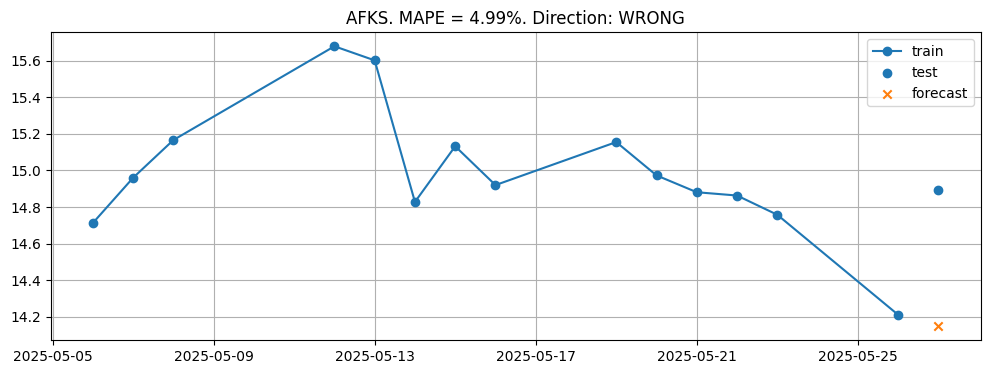

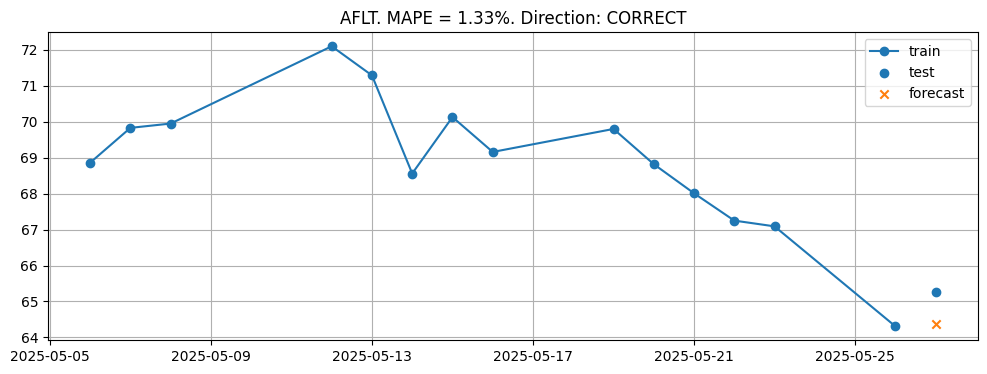

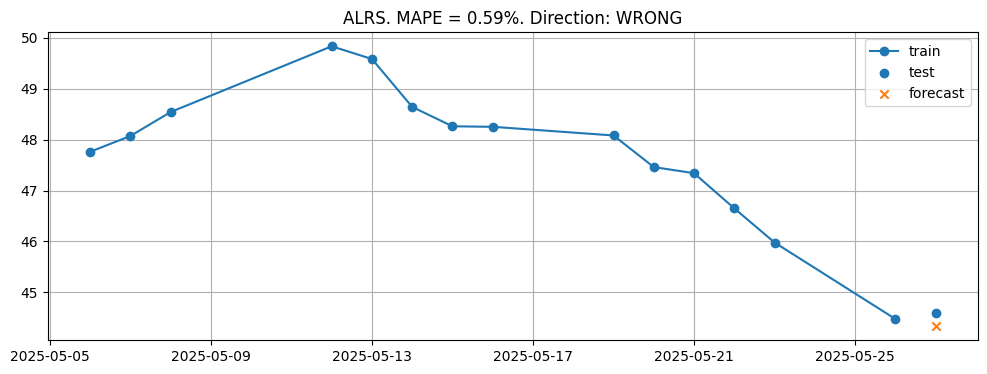

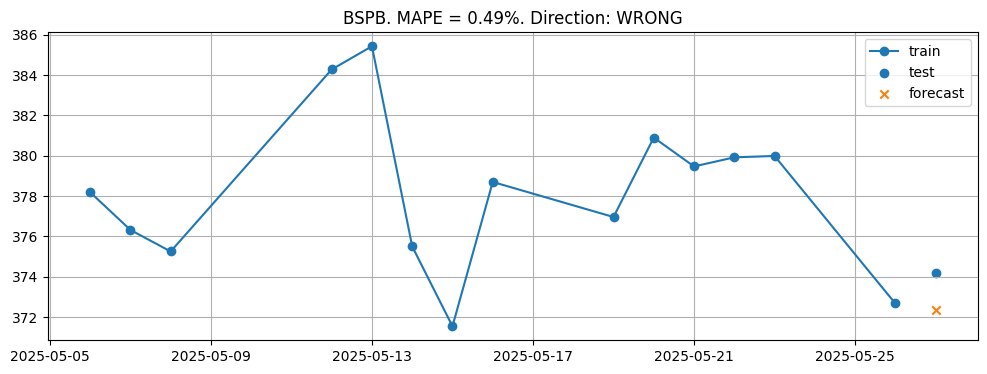

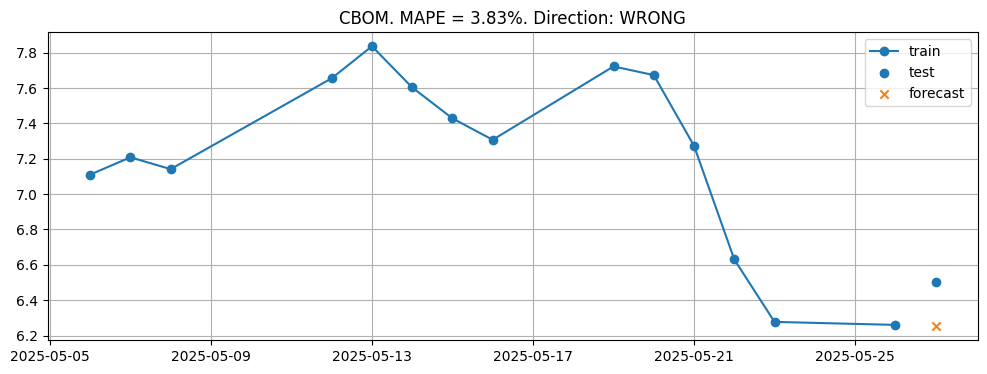

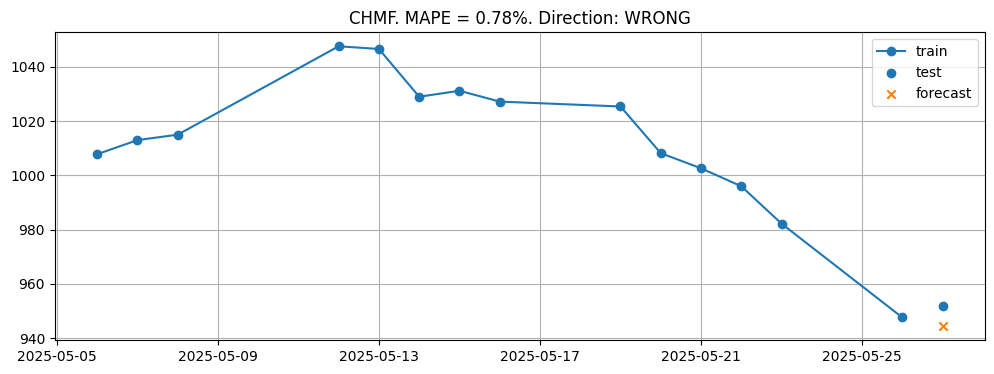

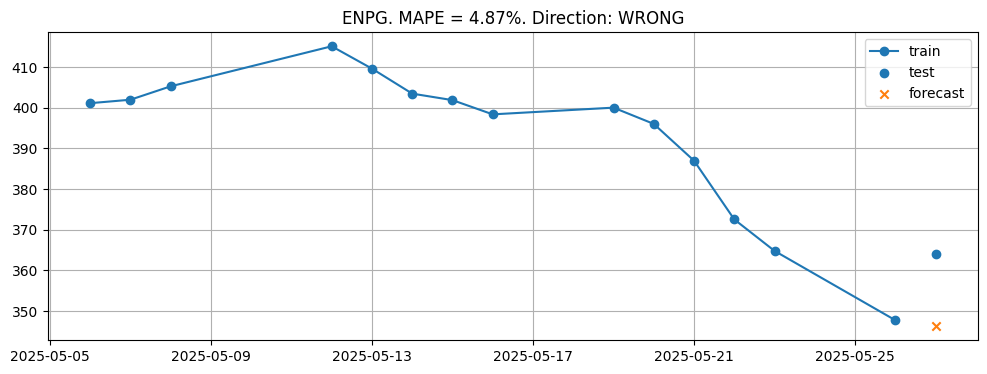

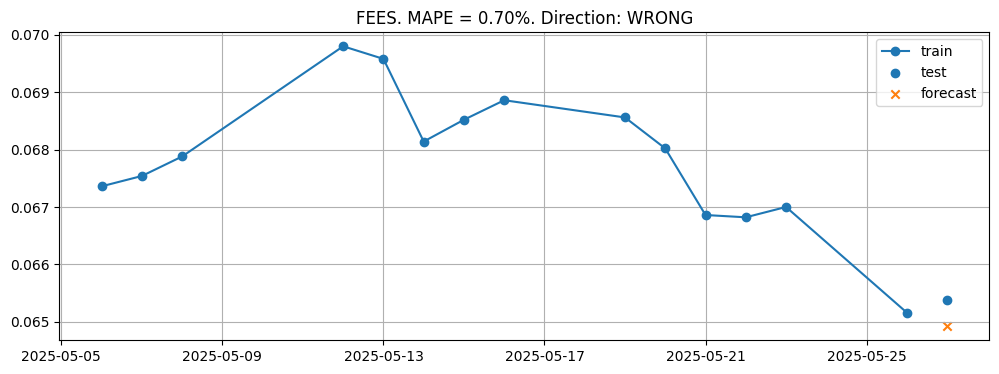

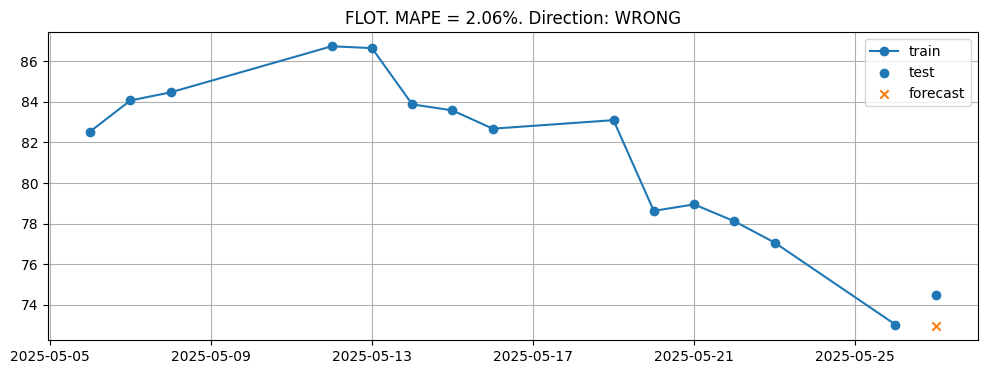

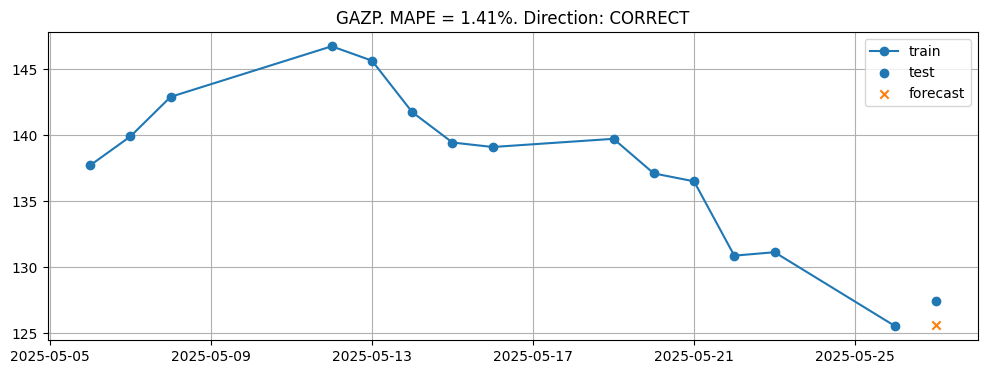

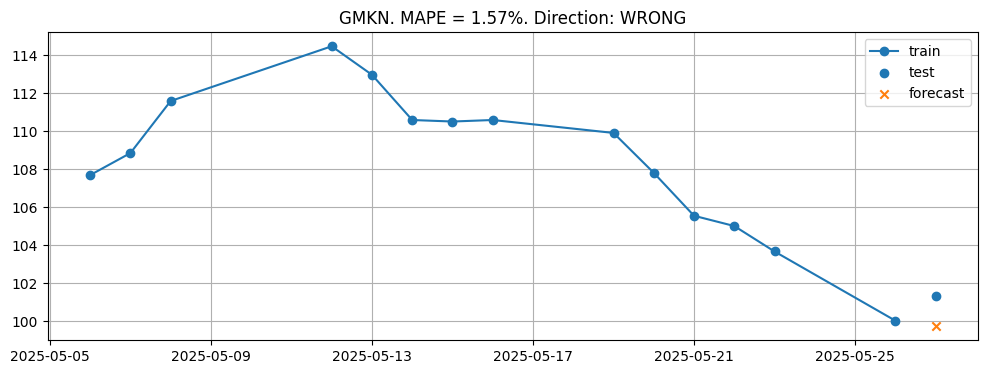

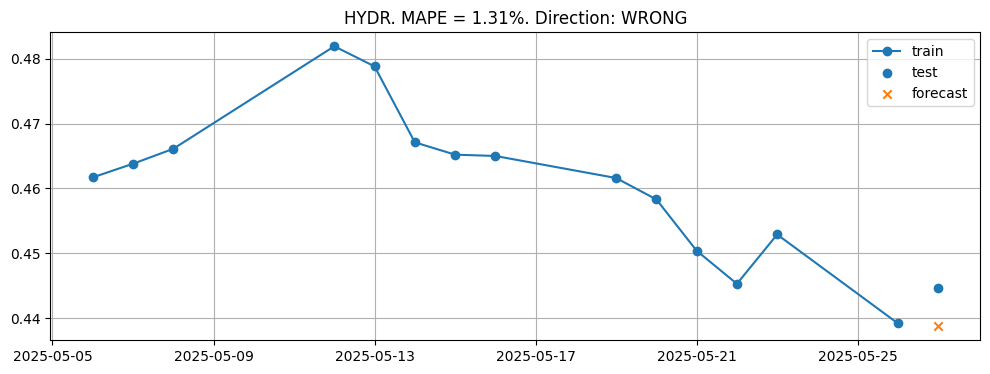

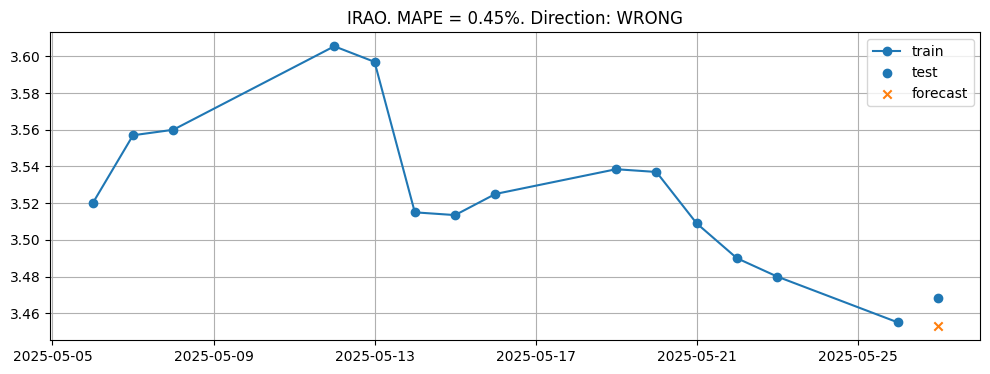

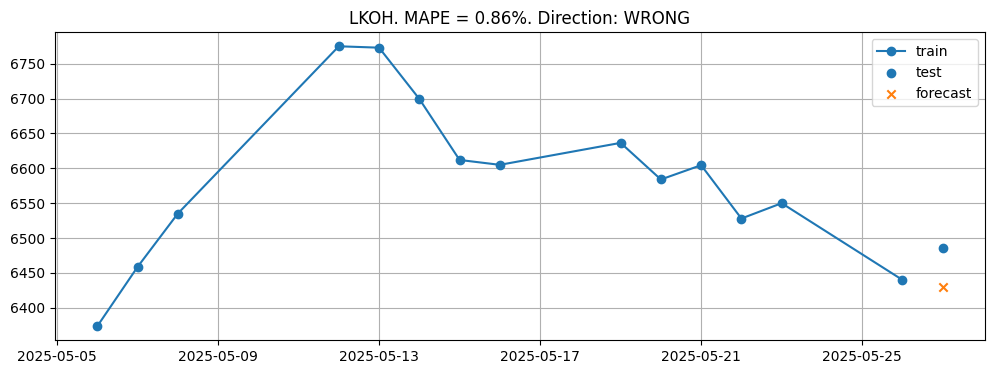

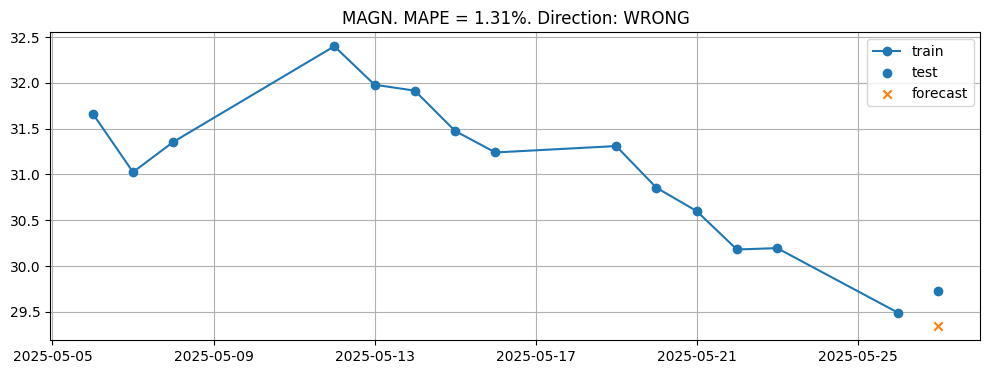

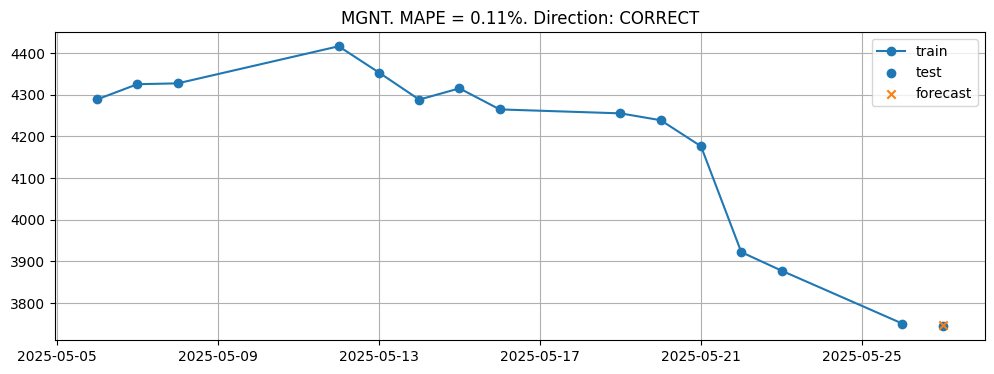

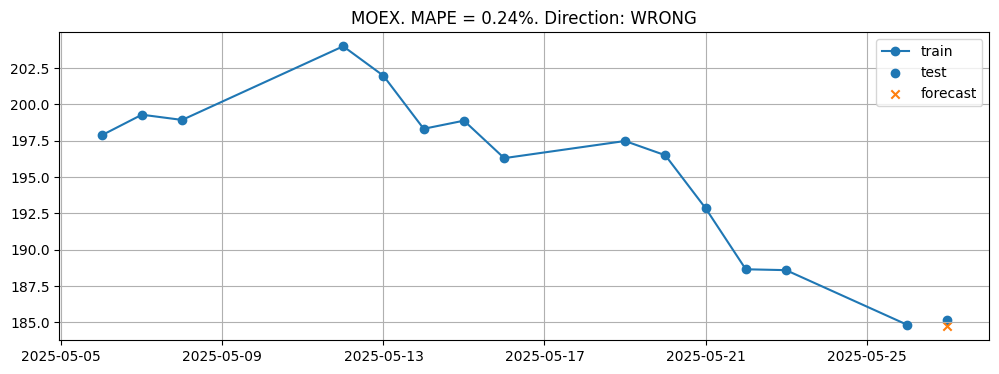

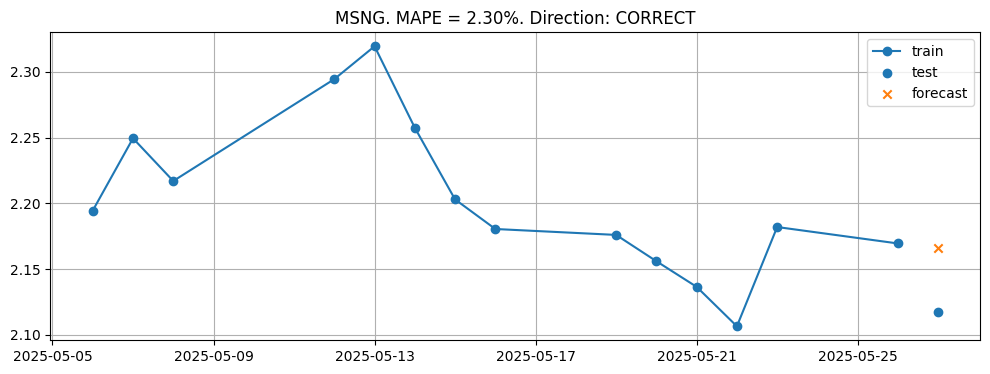

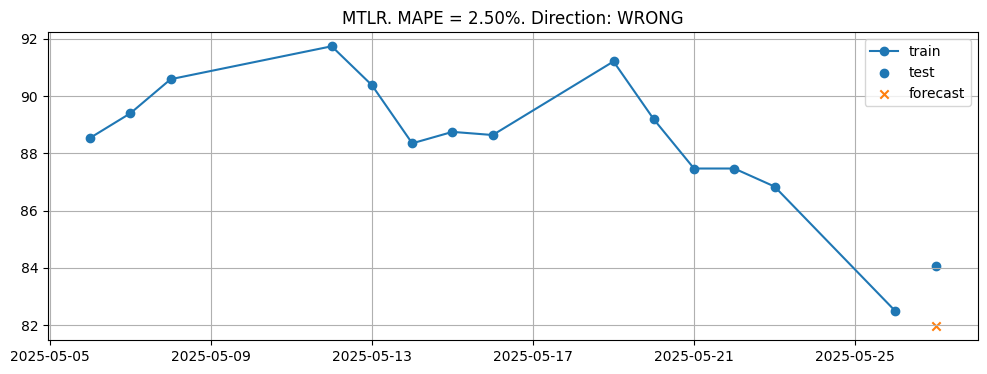

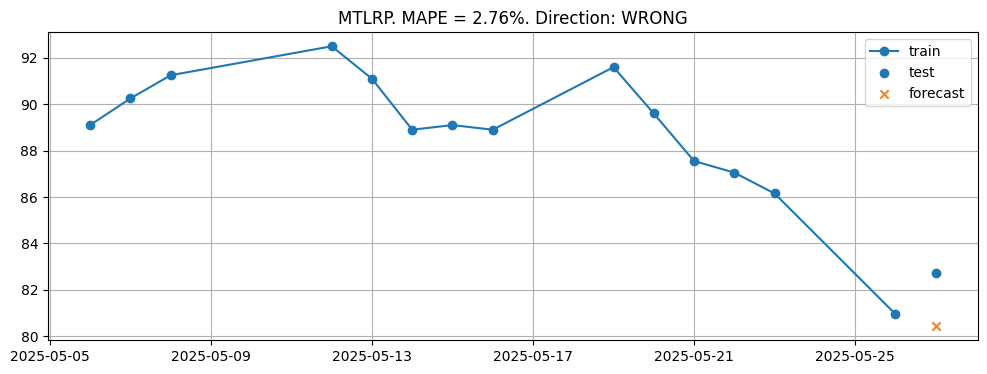

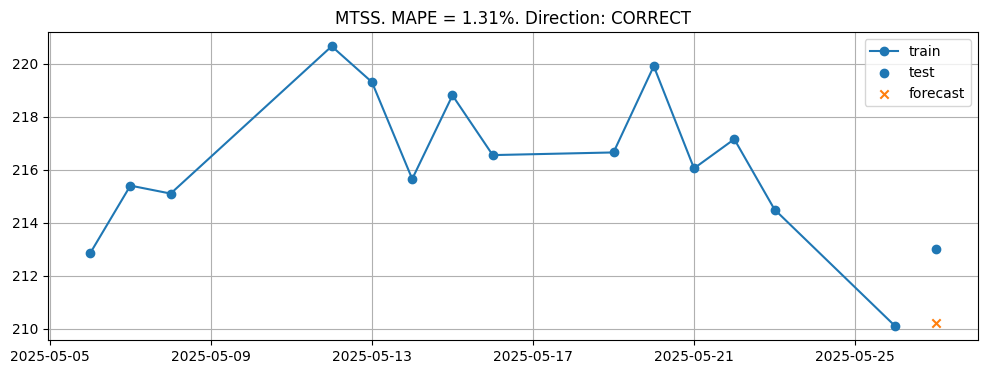

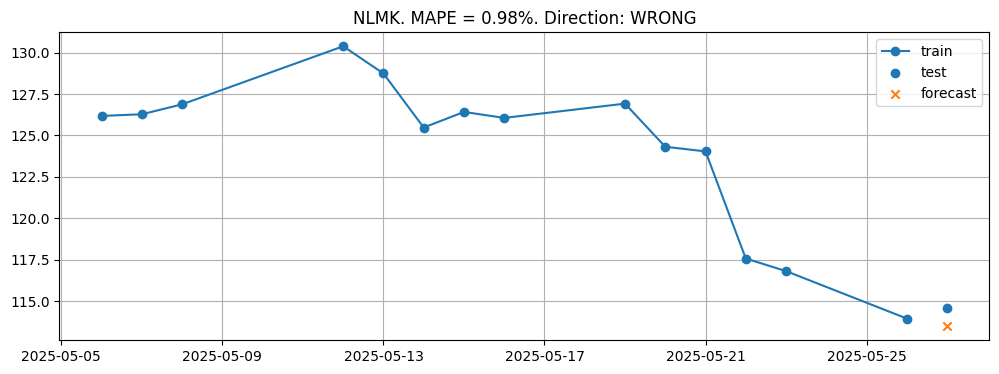

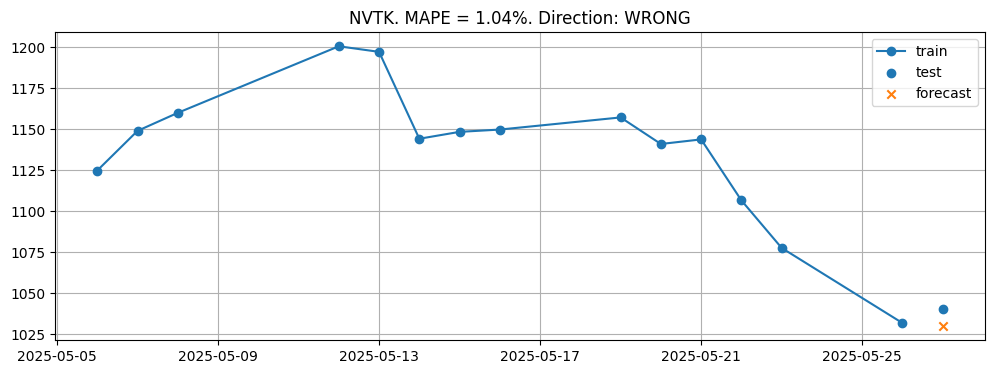

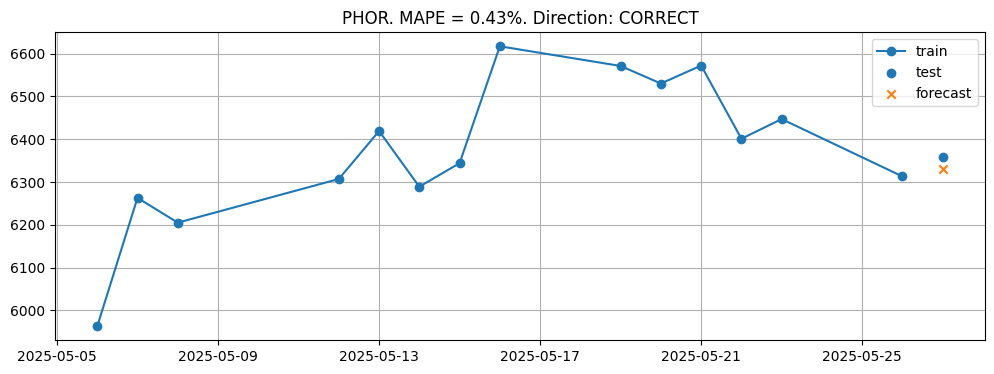

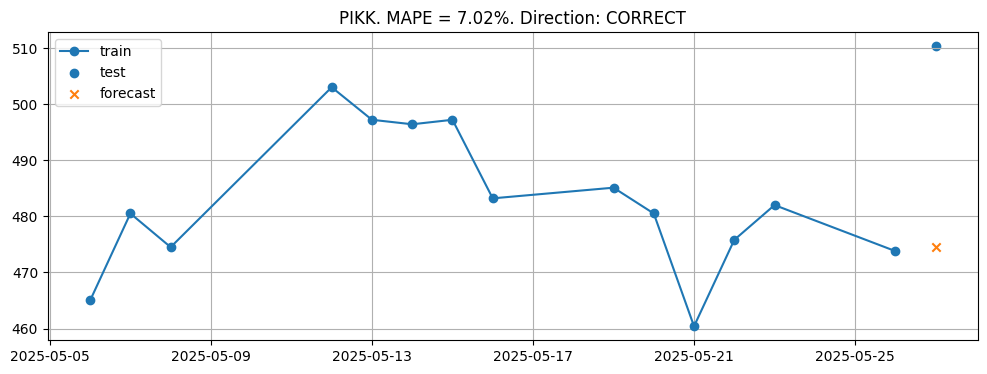

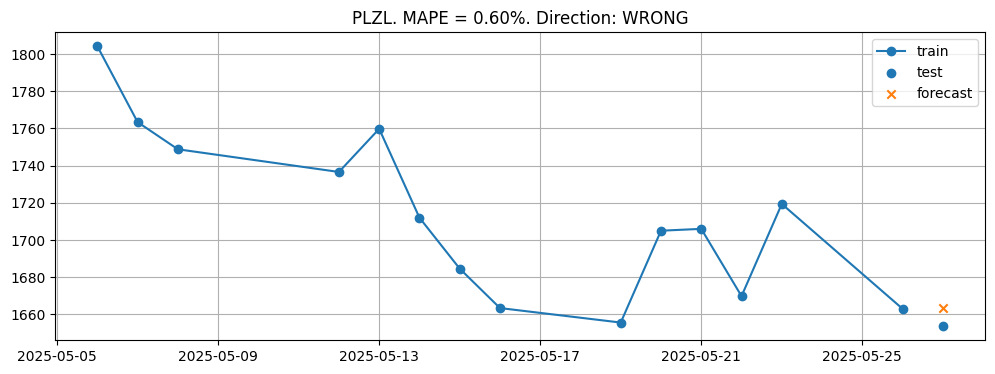

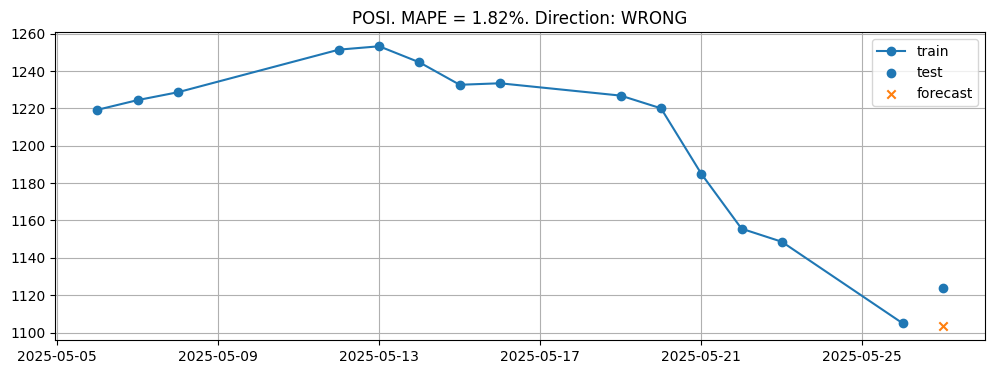

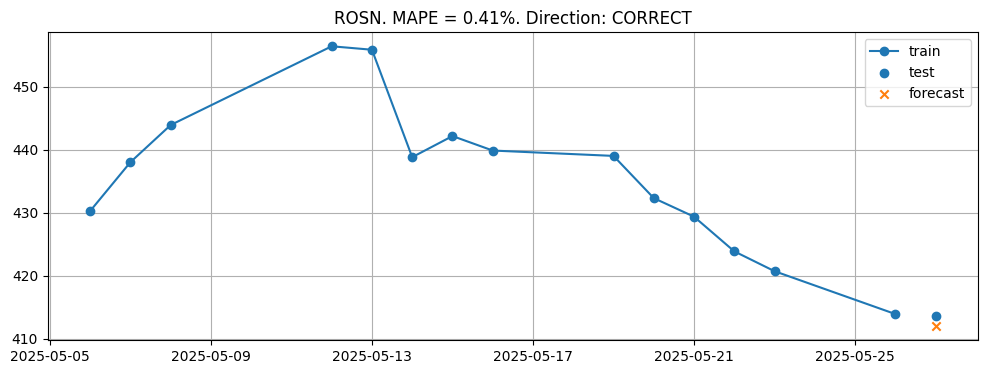

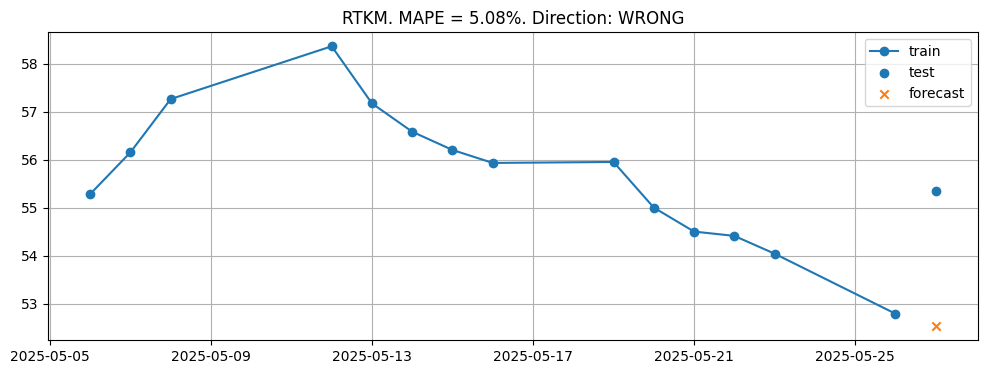

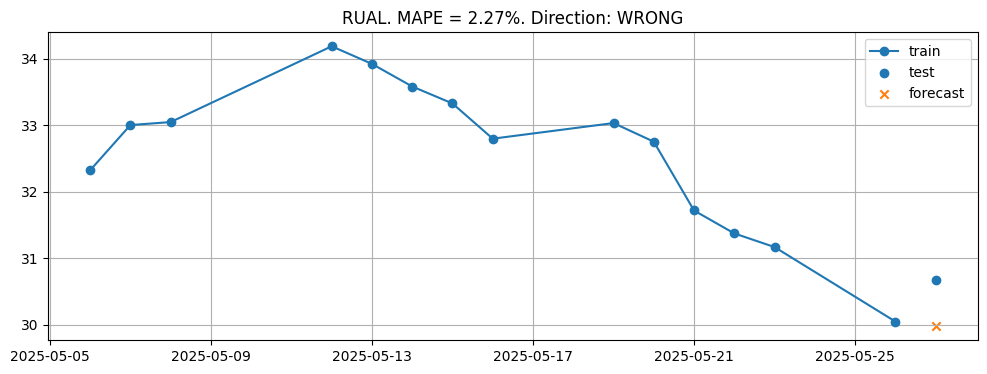

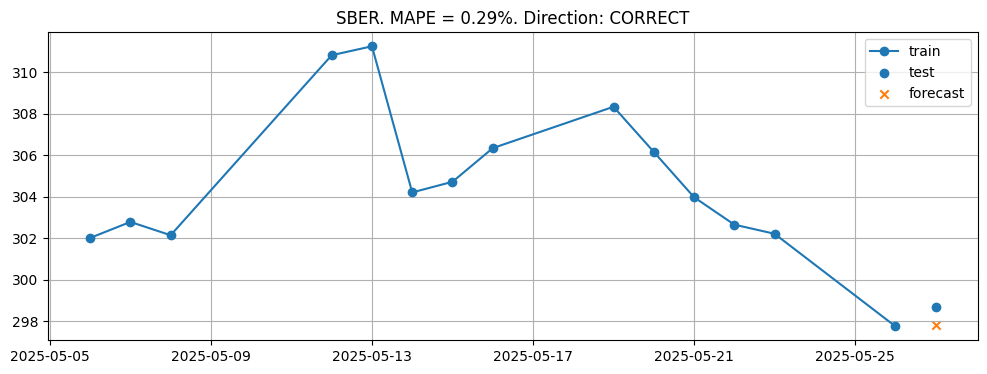

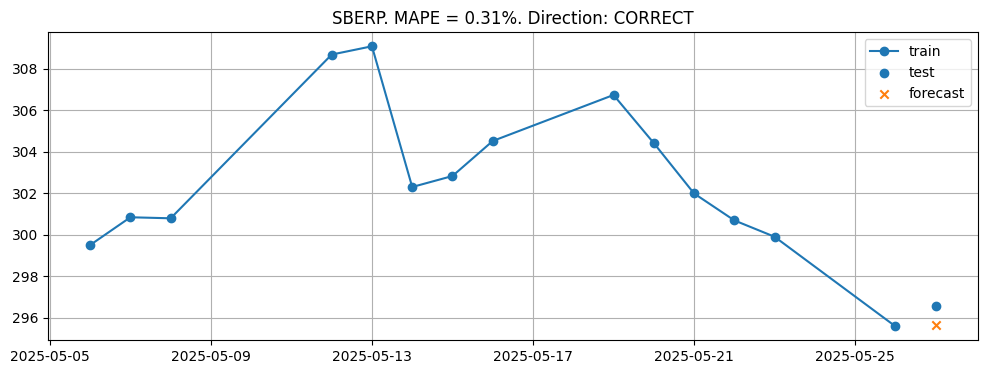

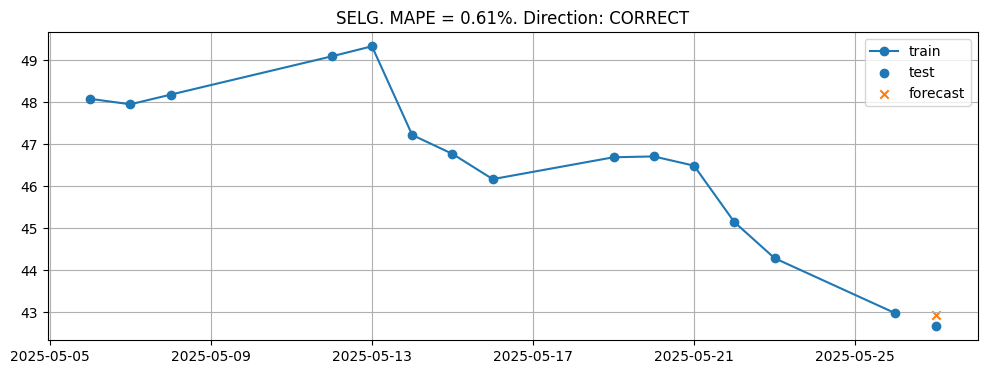

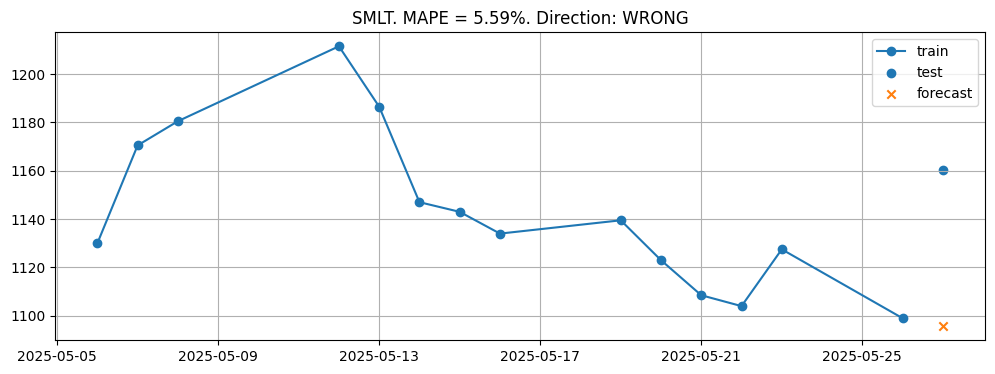

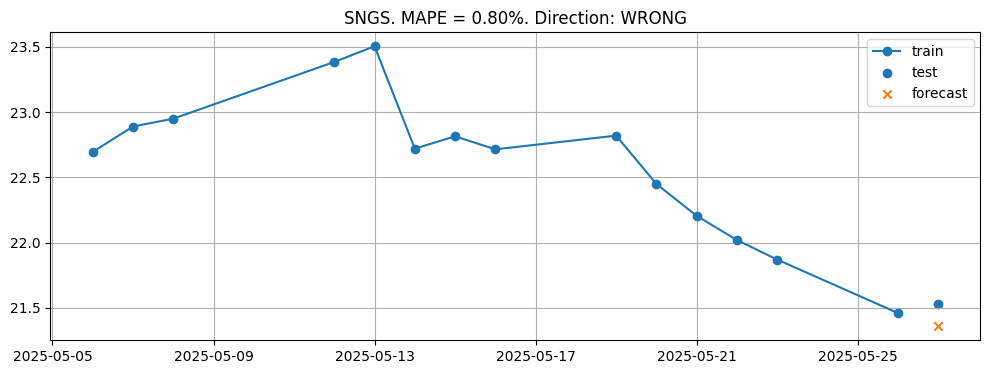

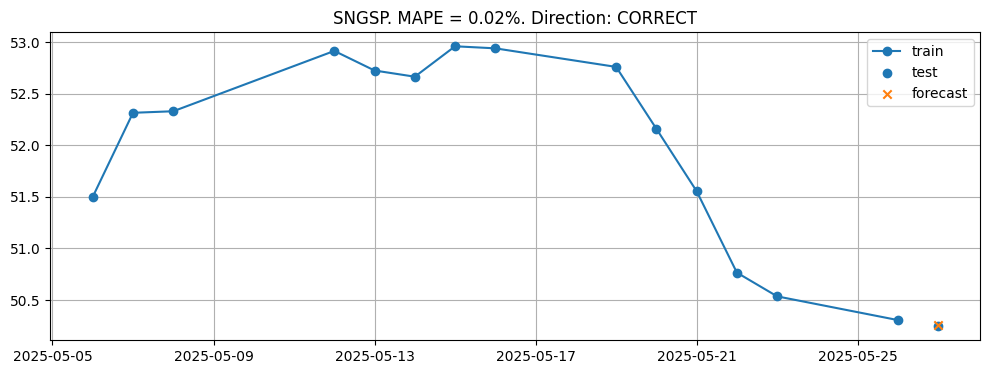

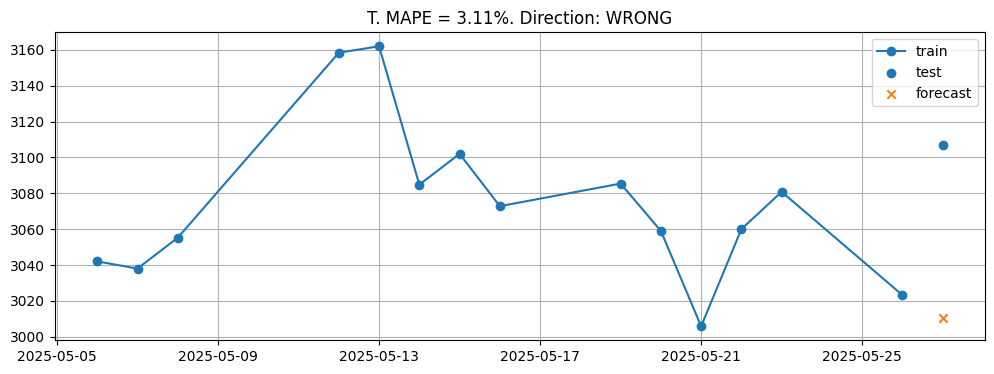

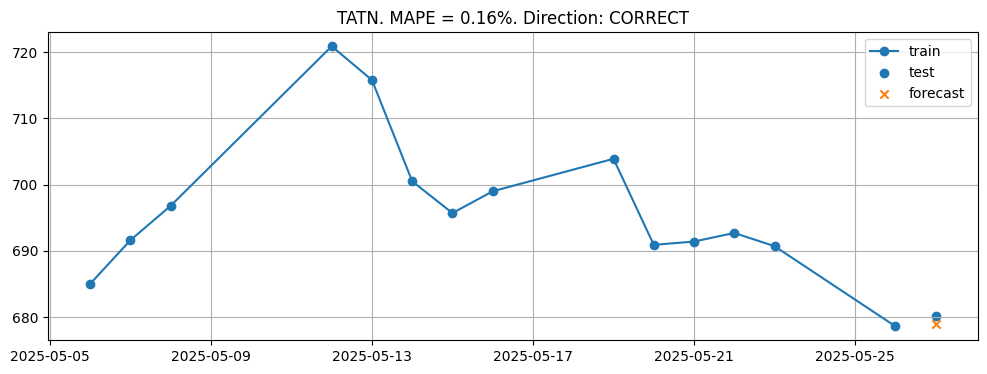

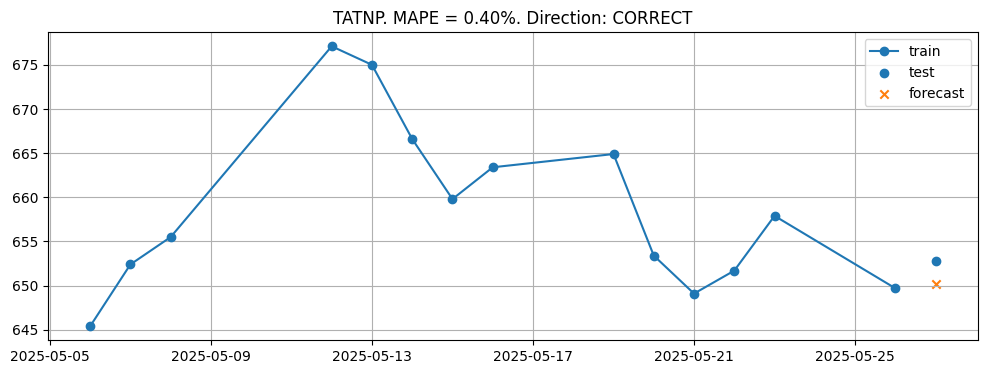

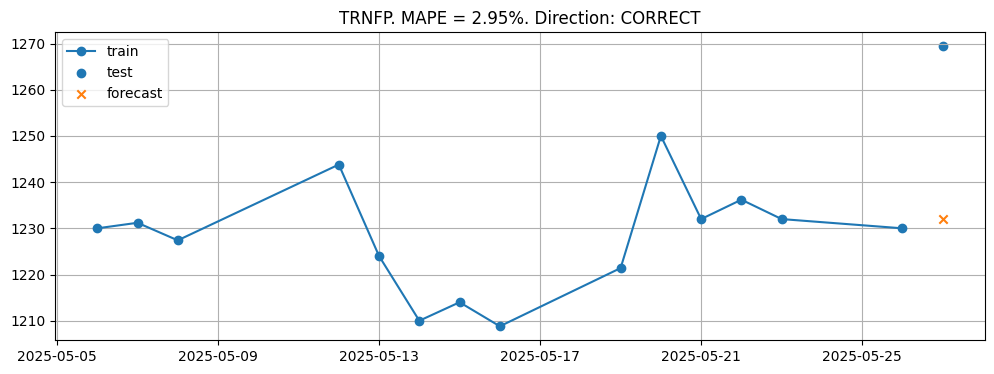

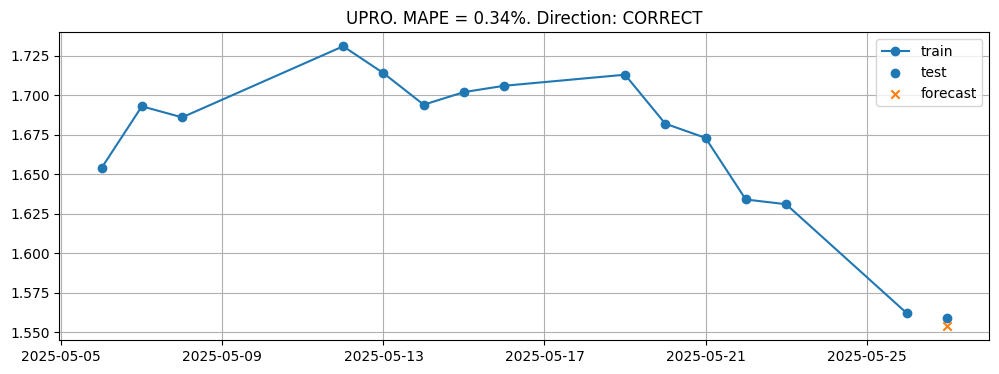

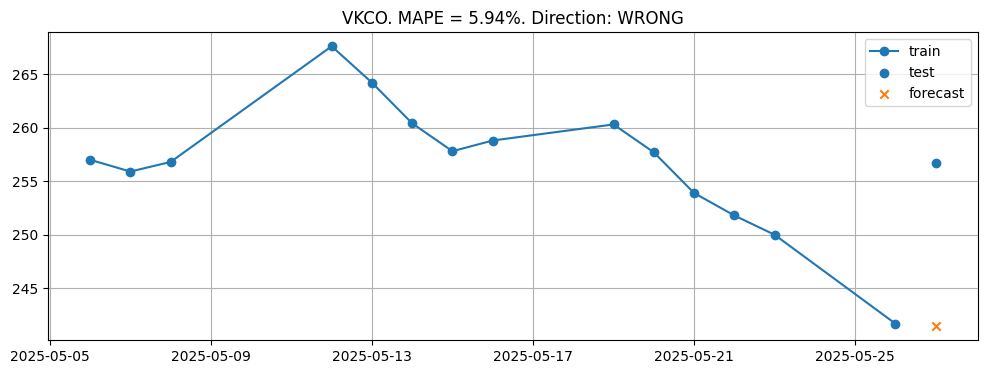

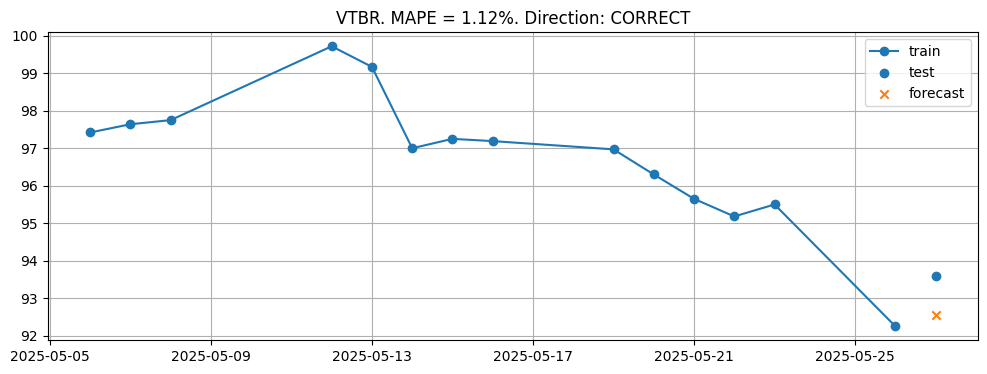

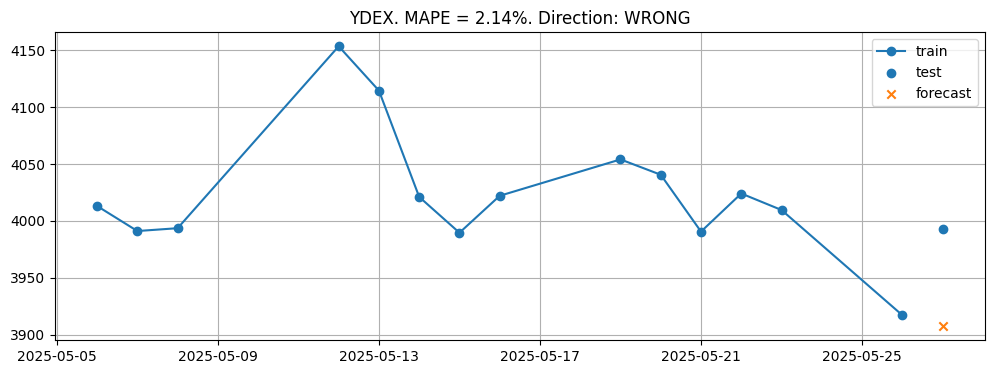

In [333]:
concatted_mlf_for_plot = concatted_mlf.copy()
concatted_mlf_for_plot['ds'] = concatted_mlf_for_plot['ds'].map(hashmap_reindex2true_dates)

for ticker in preds_best['unique_id'].unique():
    plt.figure(figsize=(12, 4))
    
    row_ticker = concatted_mlf_for_plot[(concatted_mlf_for_plot['unique_id'] == ticker) & (concatted_mlf_for_plot['ds'] >= concatted_mlf_for_plot['ds'].max() + pd.Timedelta(days=-20))]
    row_preds_best = preds_best.loc[preds_best['unique_id'] == ticker]
    row_test = preds_best.loc[(preds_best['ds'] == preds_best['ds'].max()) & (preds_best['unique_id'] == ticker)]

    forecast_point = row_preds_best['ensemble_median'].values[0]
    test_point = row_test['CLOSE'].values[0]
    train_last_point = row_ticker['y'].values[-1]

    mape_err = (np.abs(row_preds_best['ensemble_median'].values - row_test['CLOSE'].values) / row_test['CLOSE'].values)[0]
    direction_correct_flg = ( (forecast_point > train_last_point) == (test_point > train_last_point) )

    plt.title(f'{ticker}. MAPE = {mape_err:.2%}. Direction: {"CORRECT" if direction_correct_flg == 1 else "WRONG"}')
    plt.plot(row_ticker['ds'], row_ticker['y'], label='train', marker='o')
    plt.scatter(row_preds_best['ds'], row_test['CLOSE'], label='test')
    plt.scatter(row_preds_best['ds'], row_preds_best['ensemble_median'], marker='x', label='forecast')

    plt.grid()
    plt.legend()

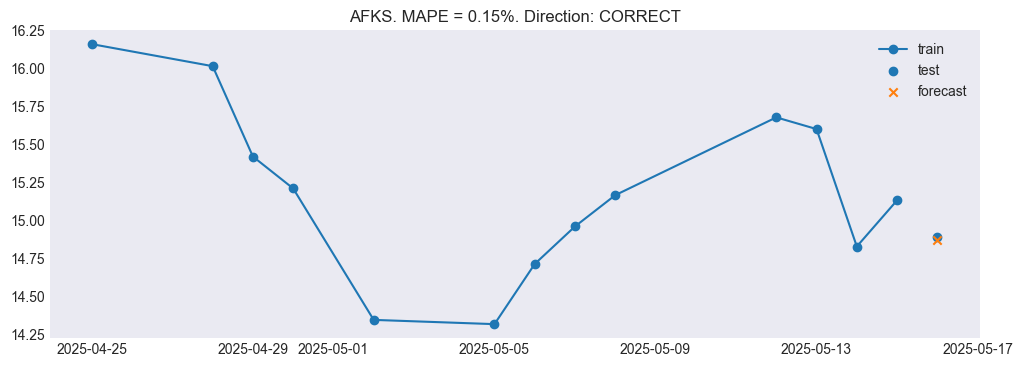

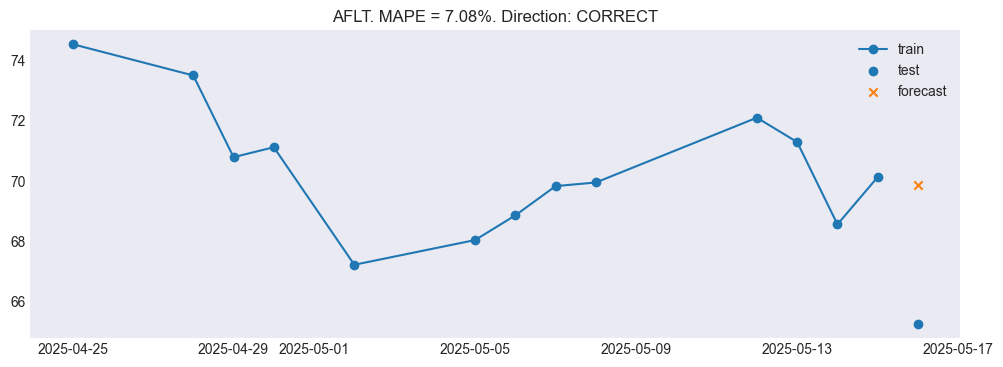

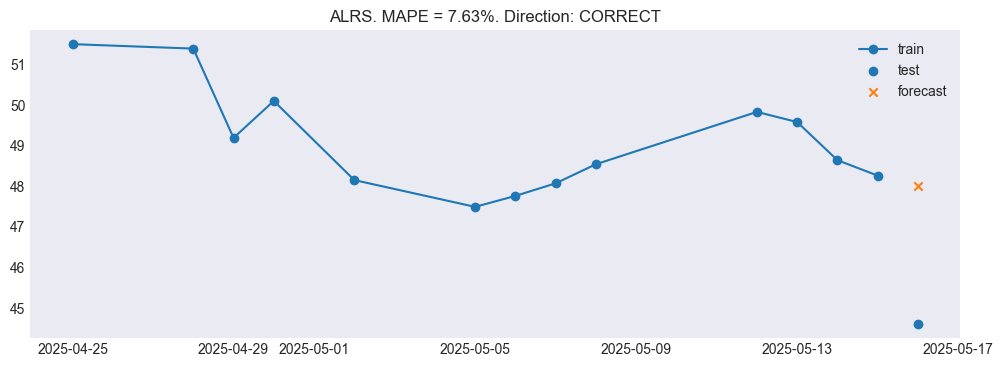

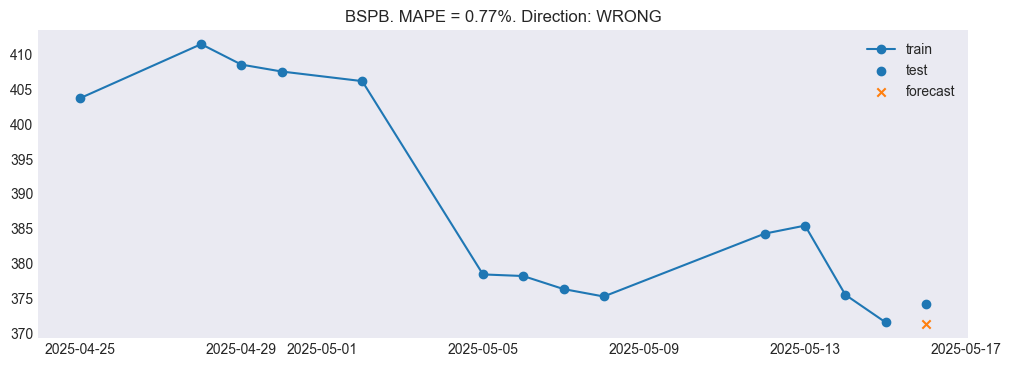

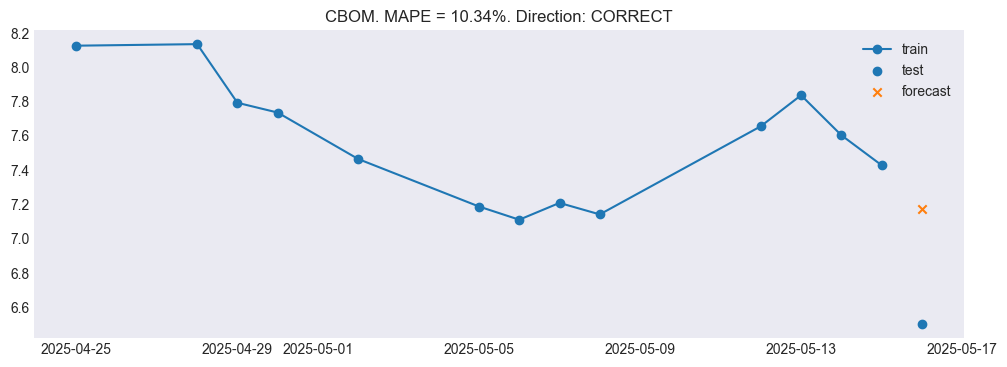

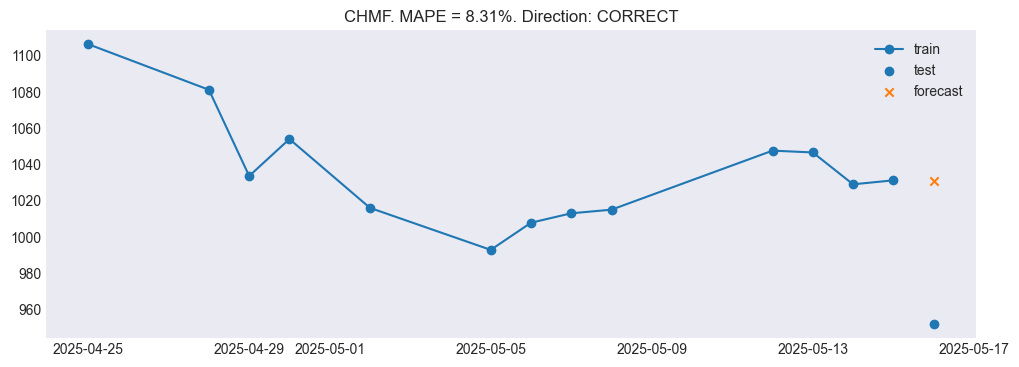

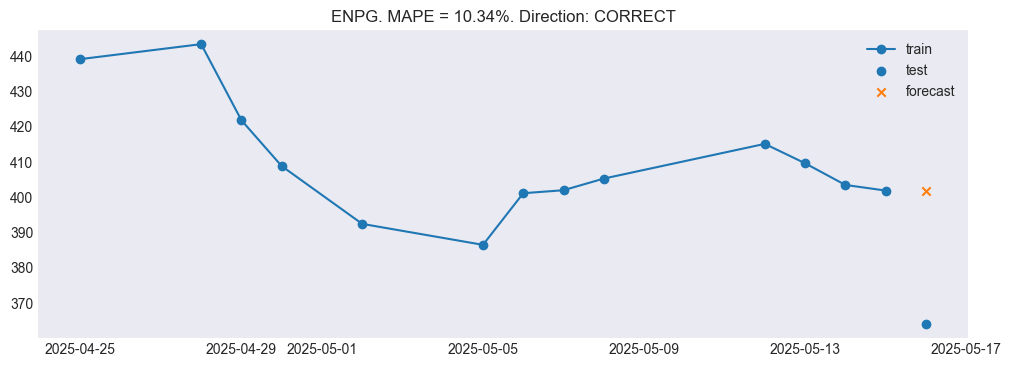

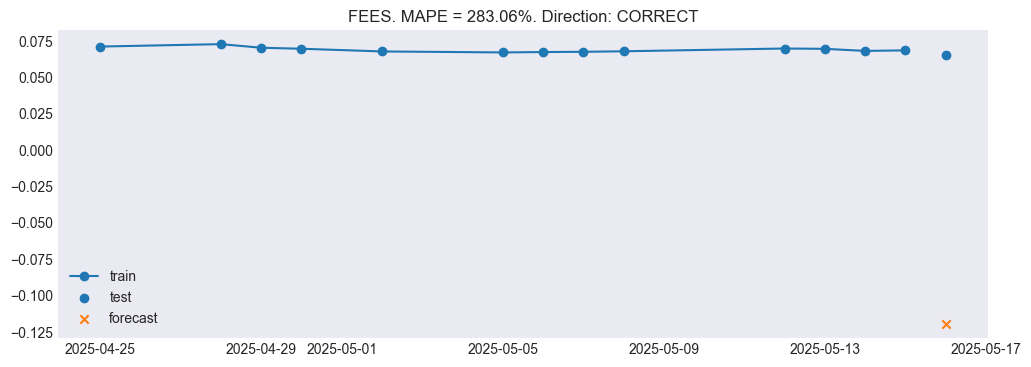

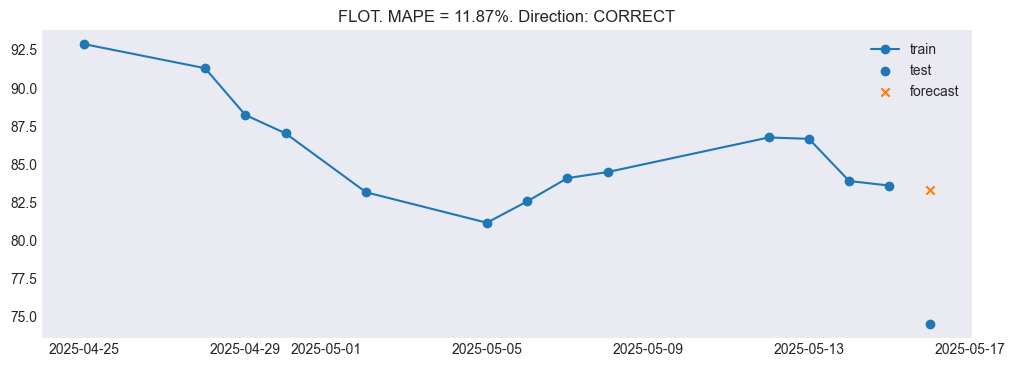

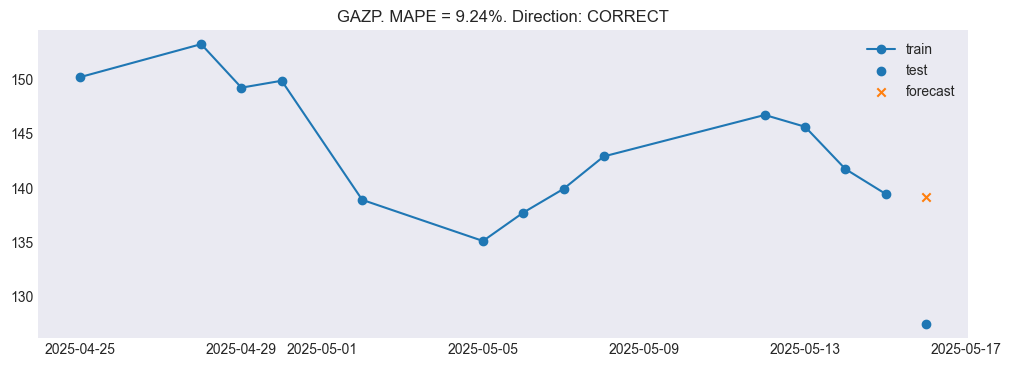

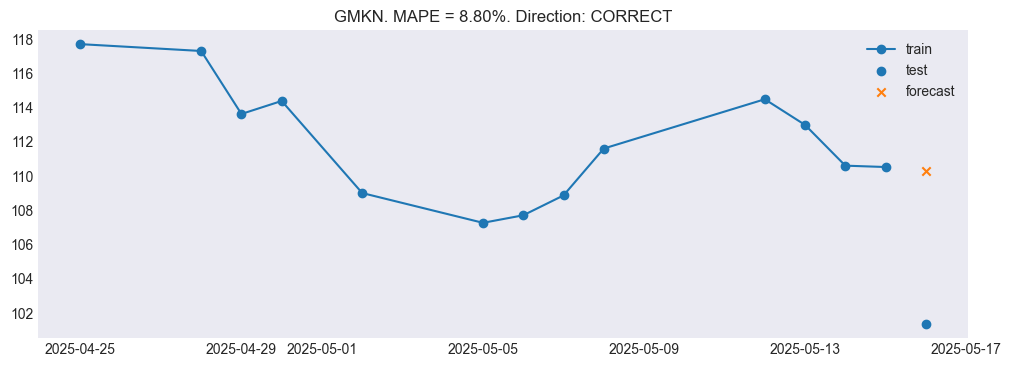

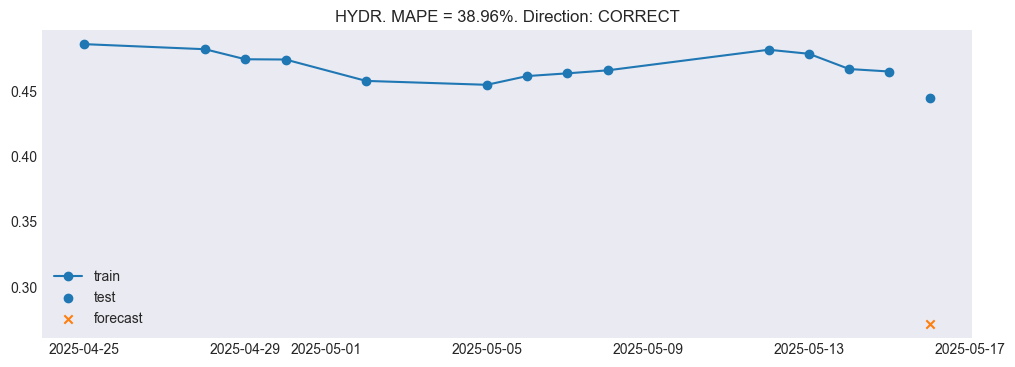

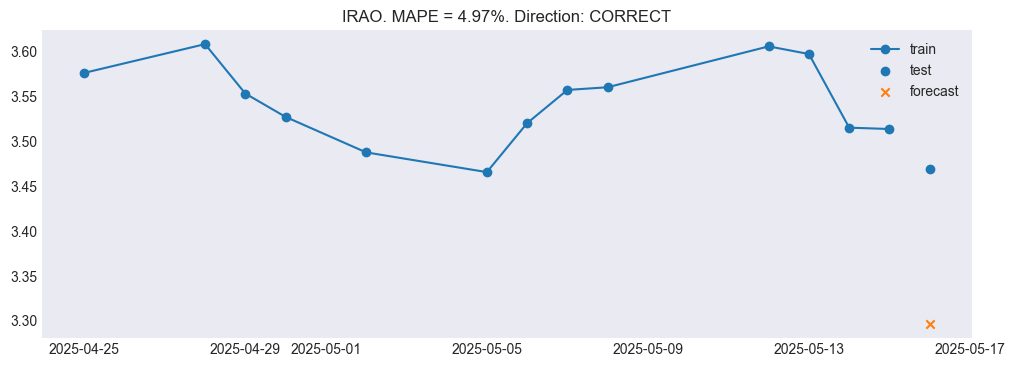

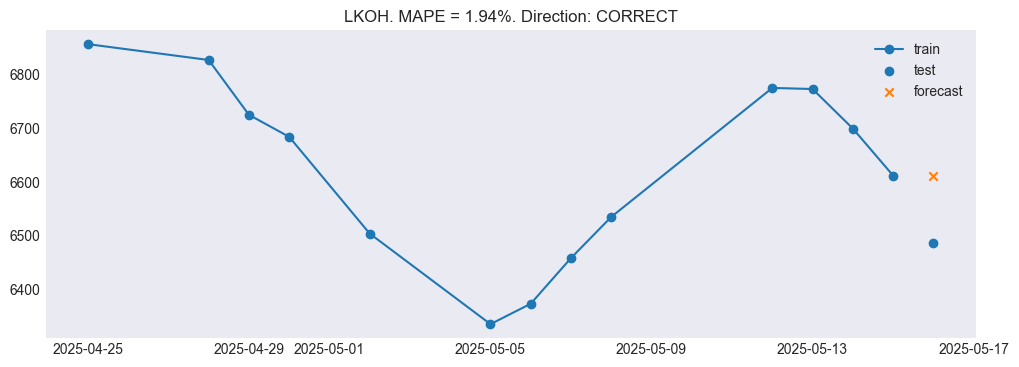

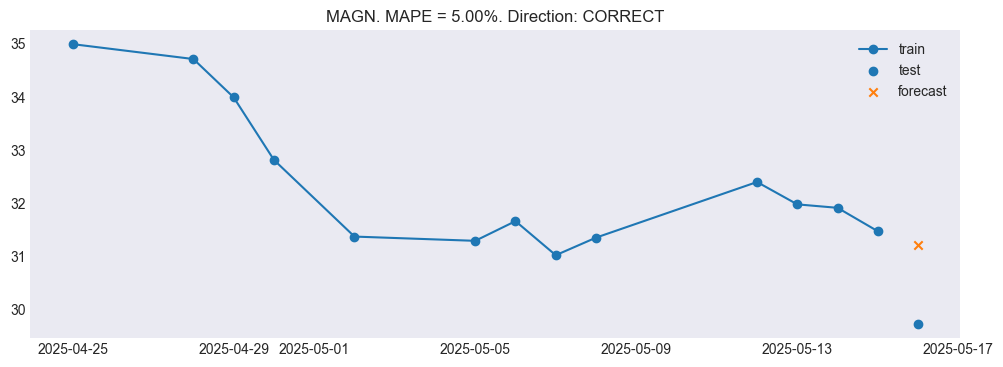

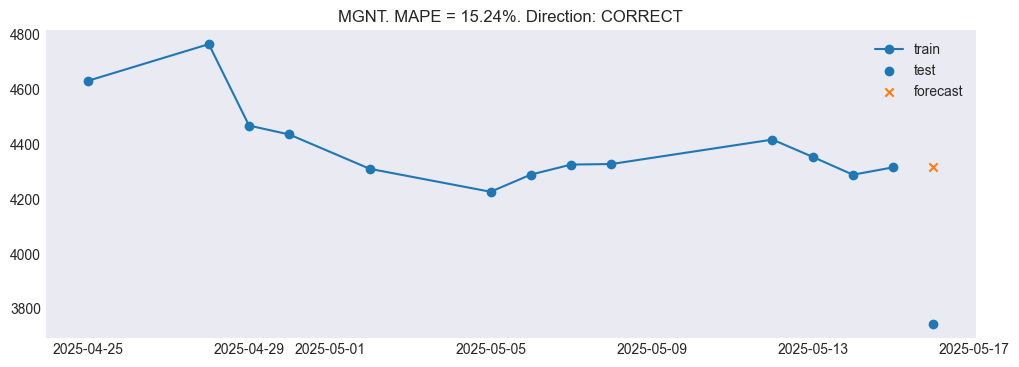

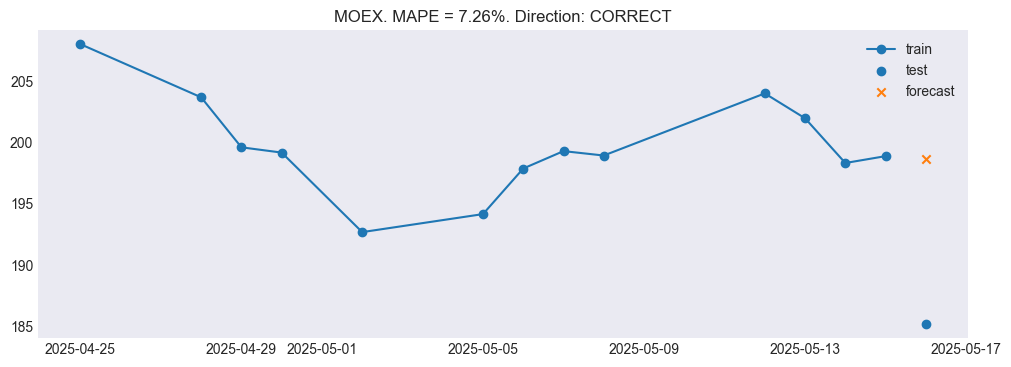

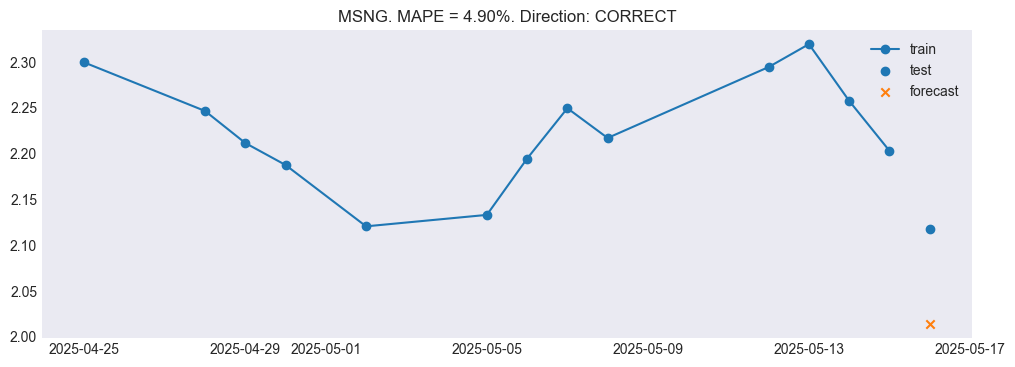

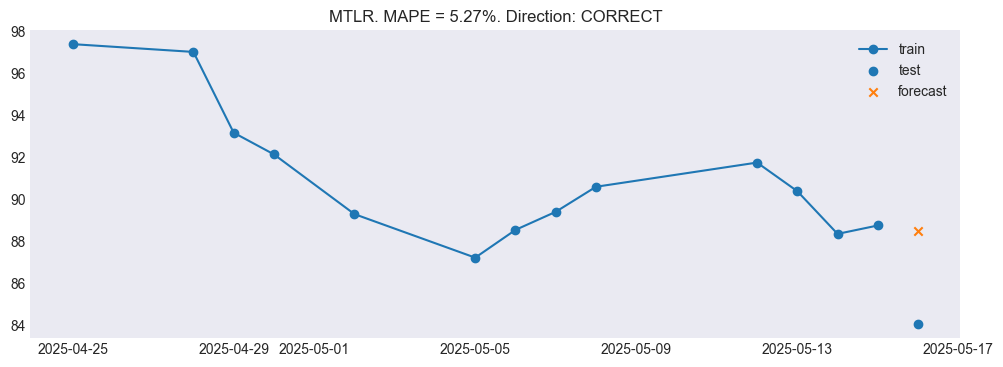

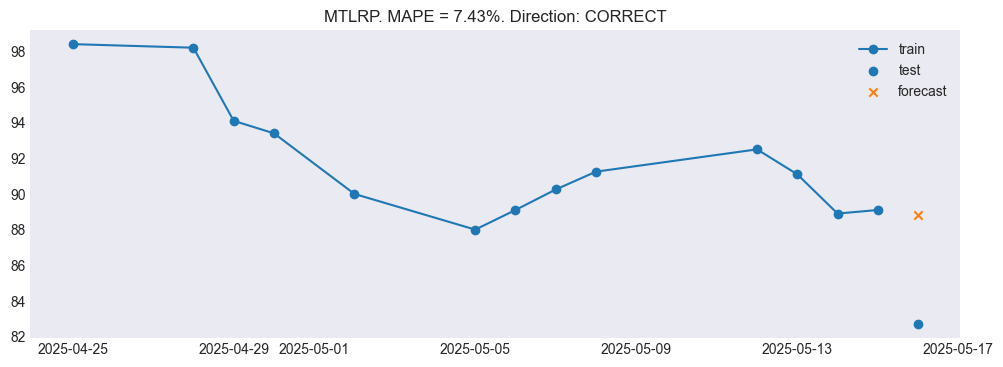

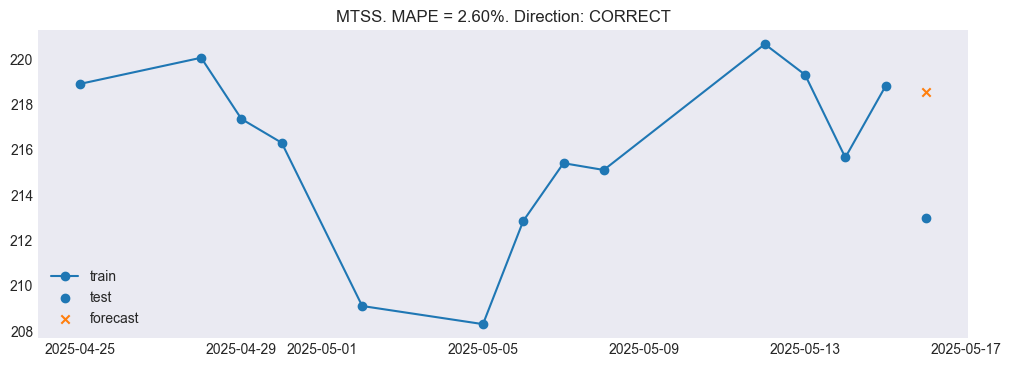

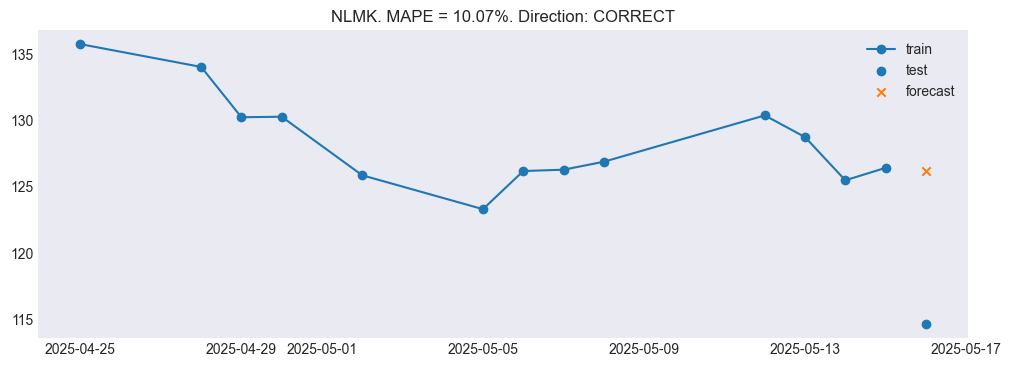

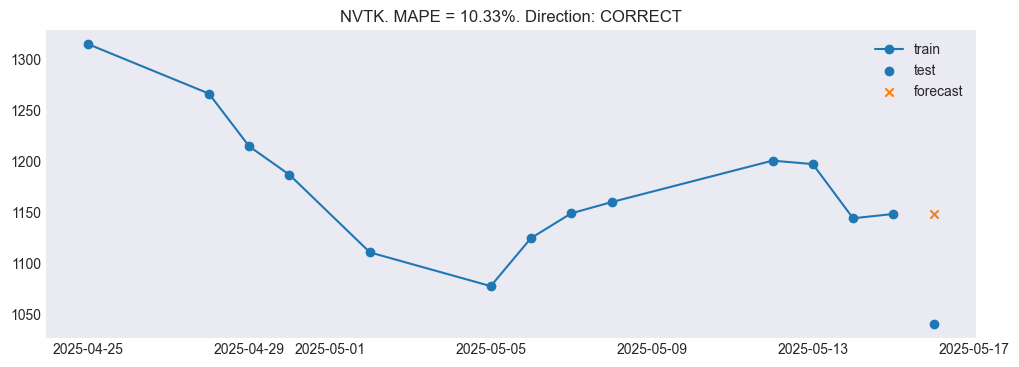

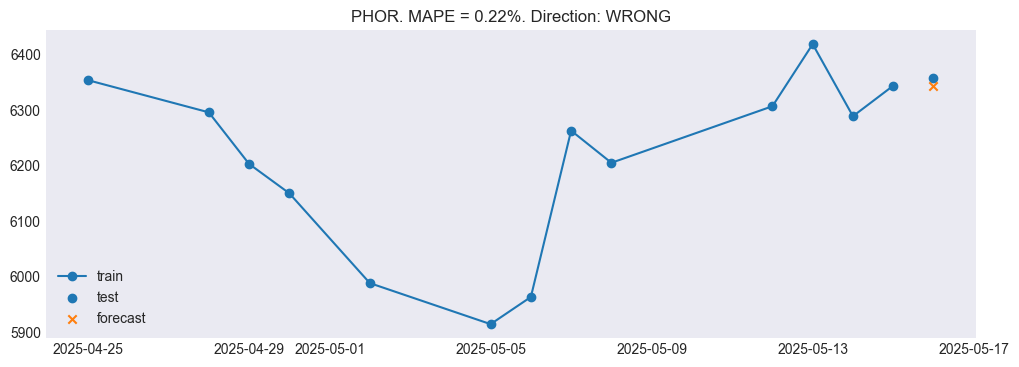

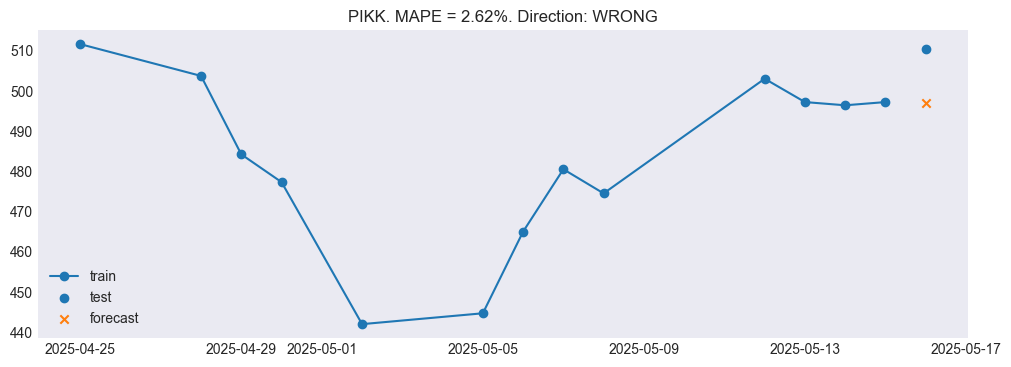

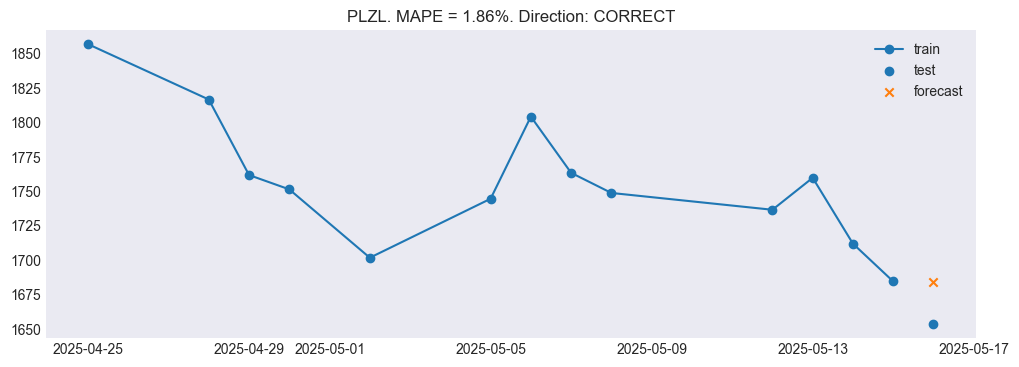

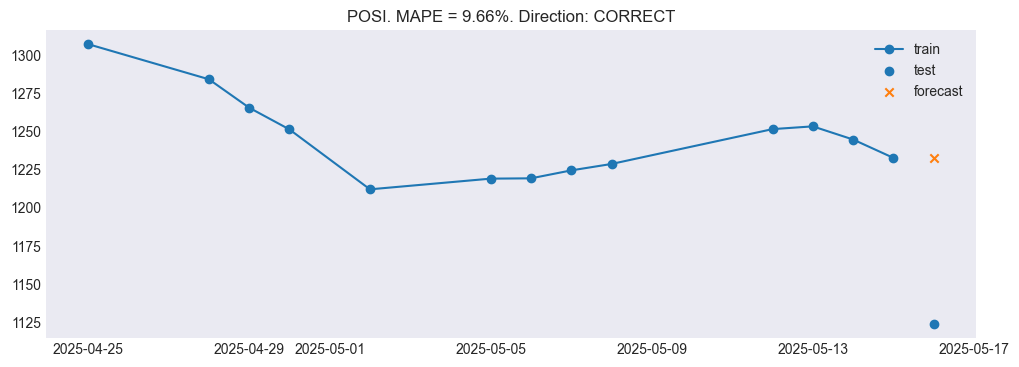

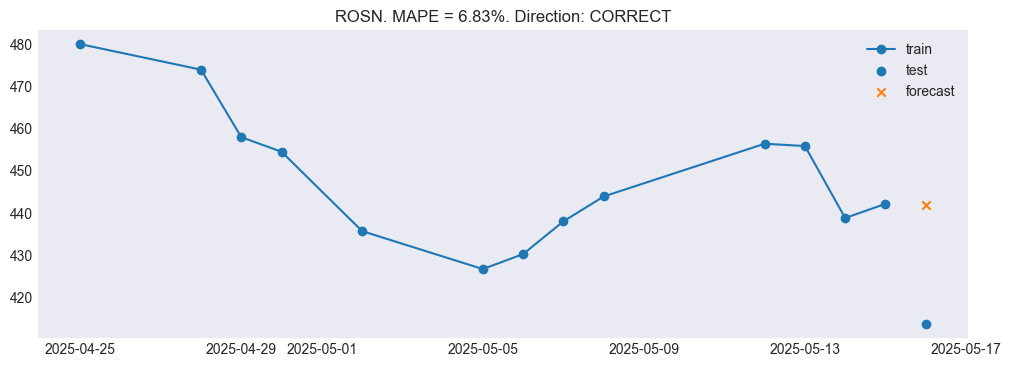

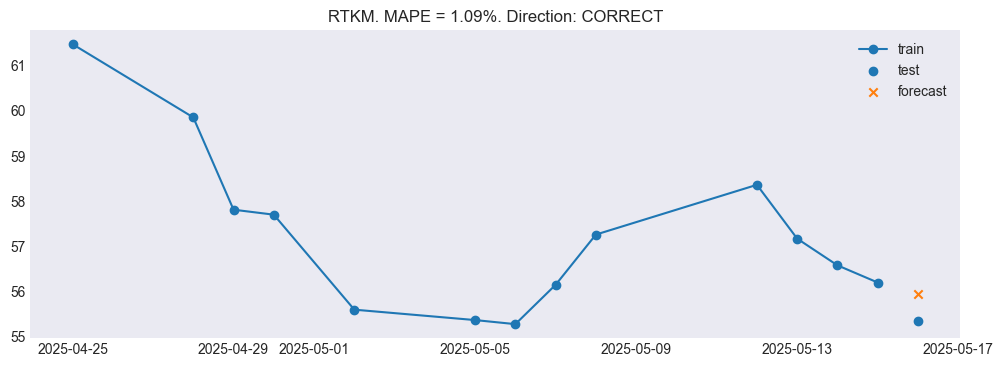

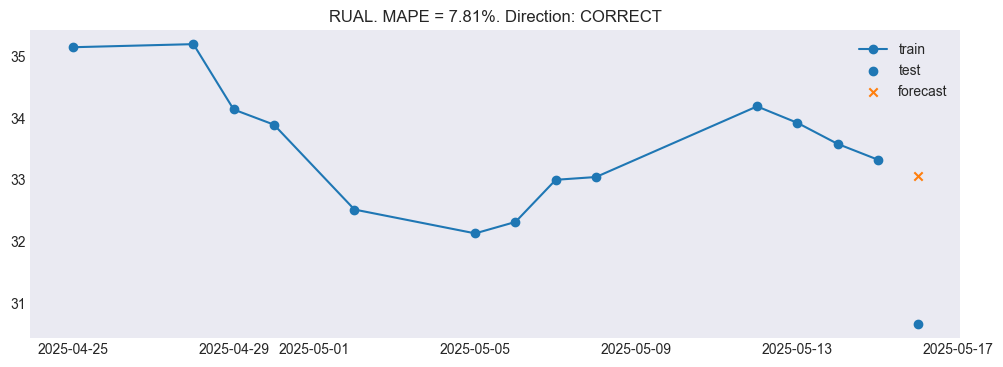

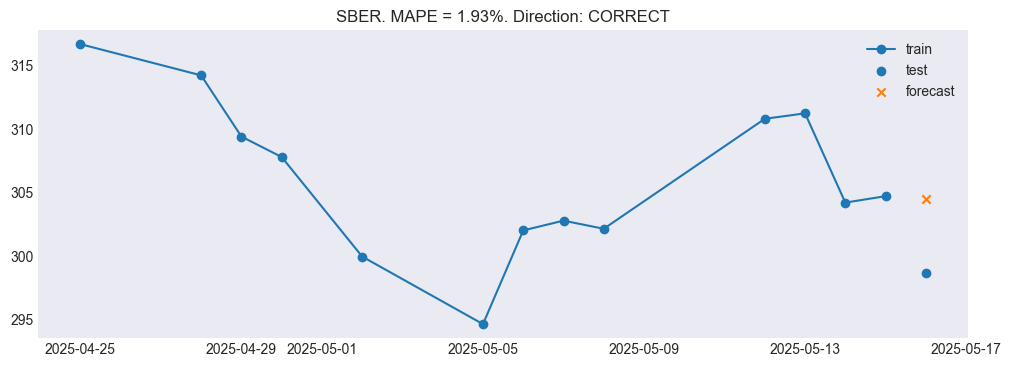

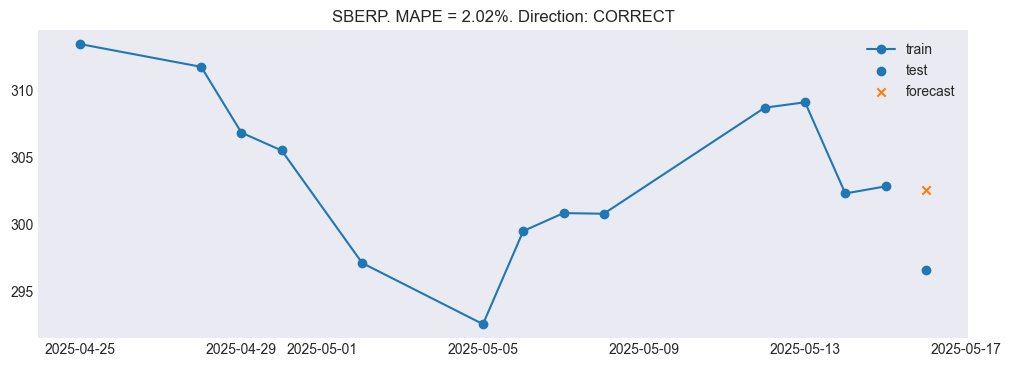

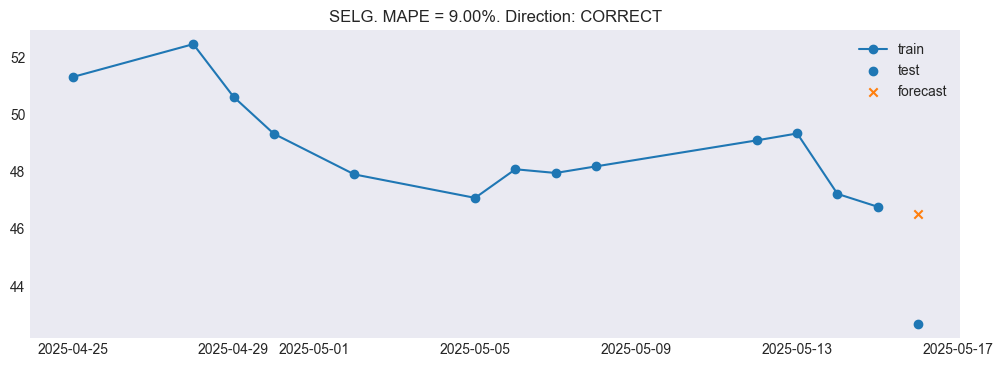

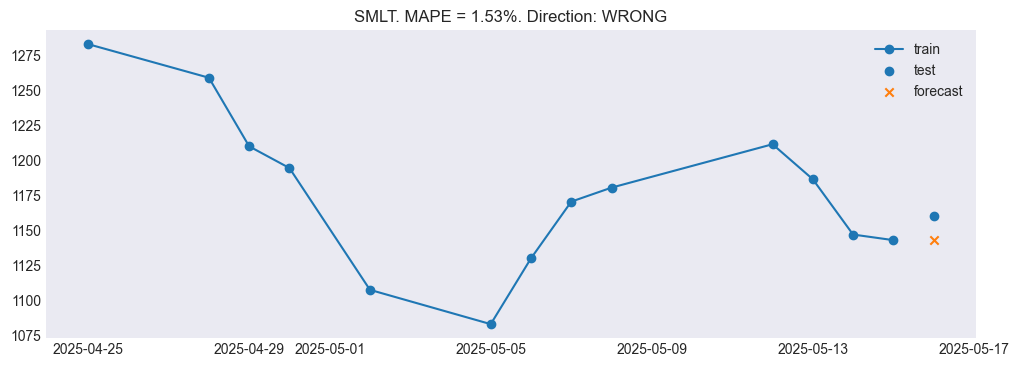

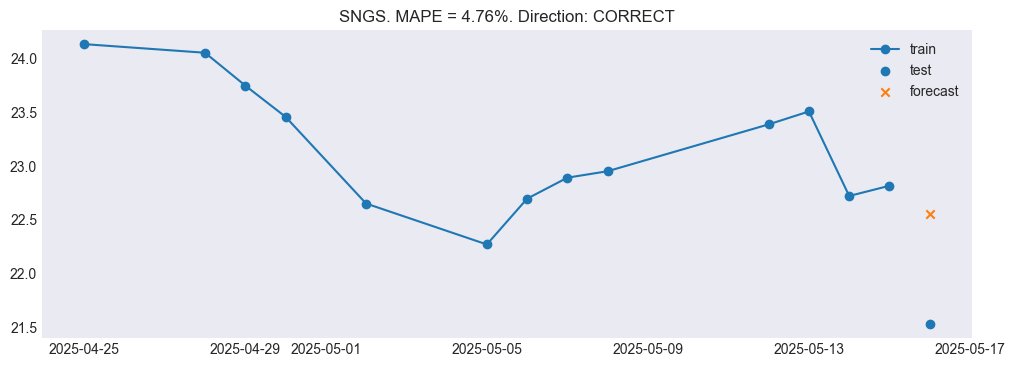

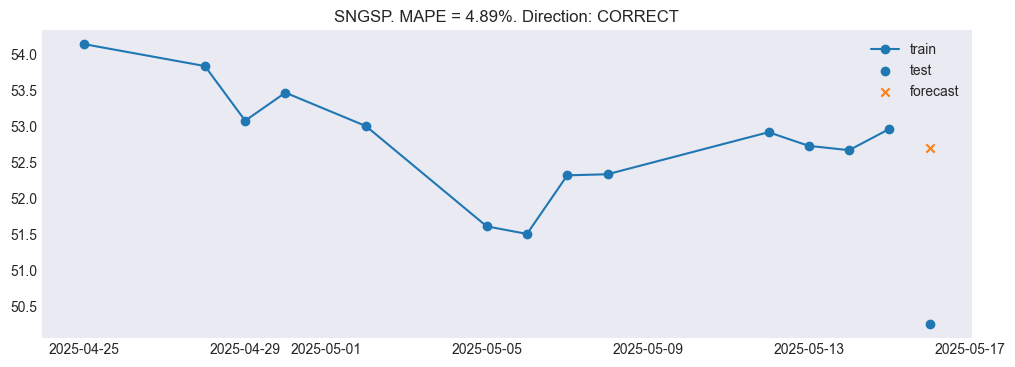

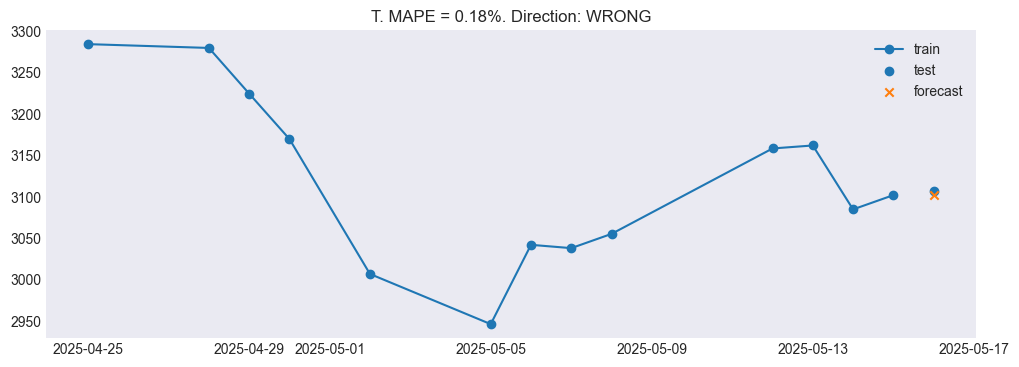

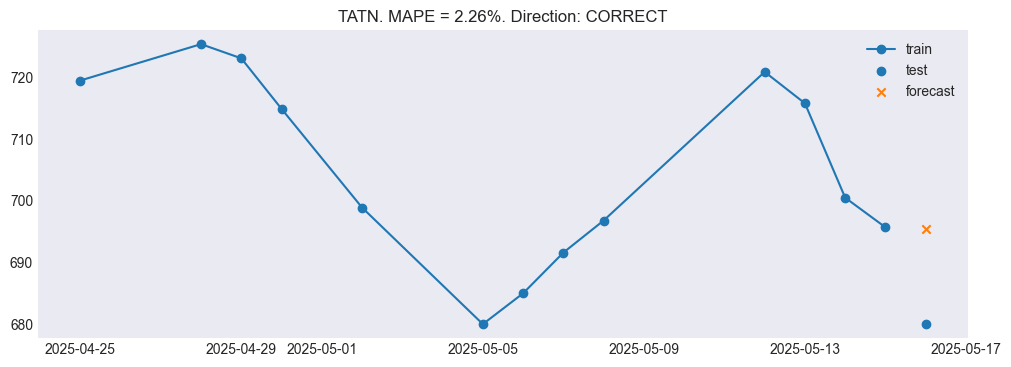

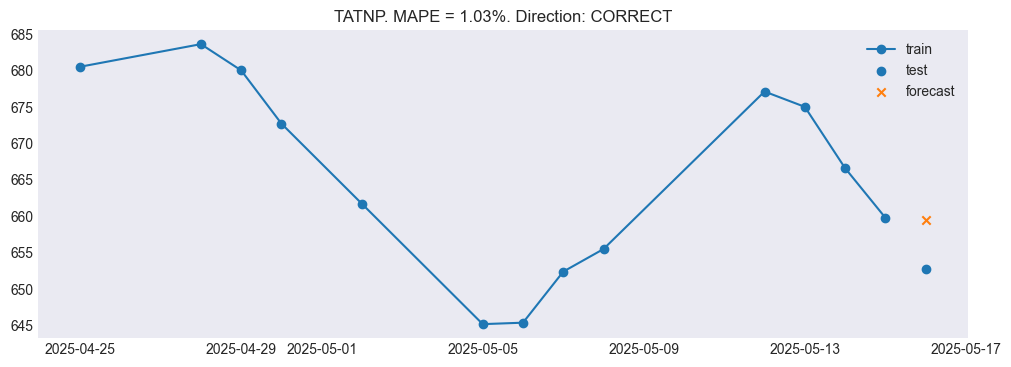

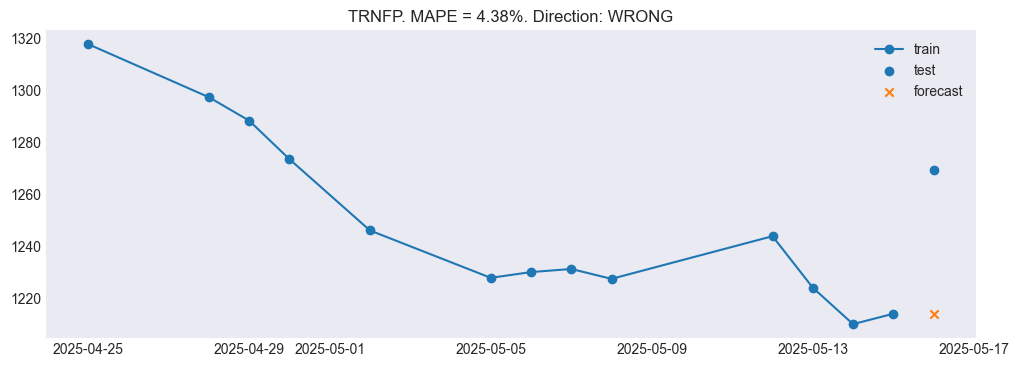

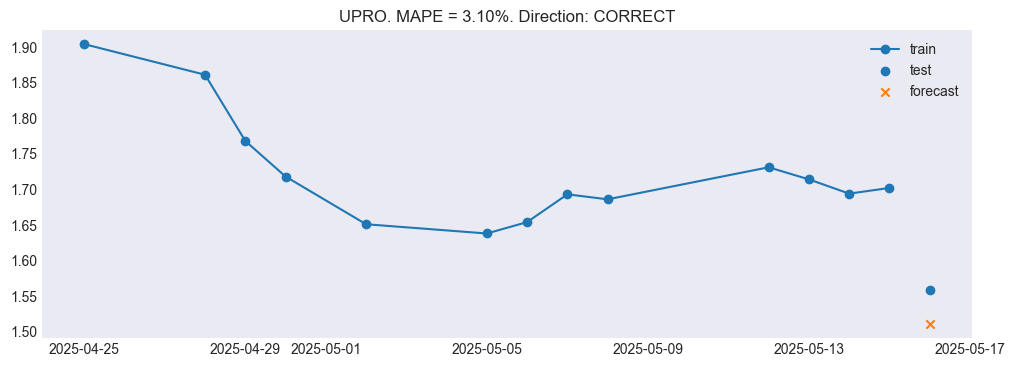

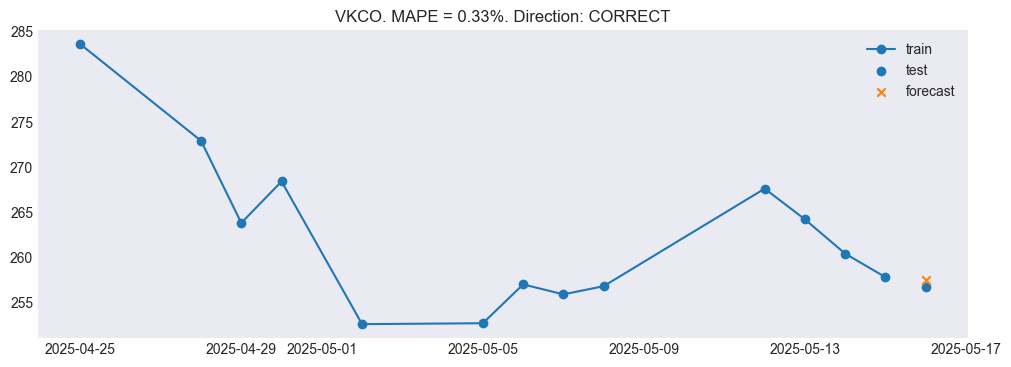

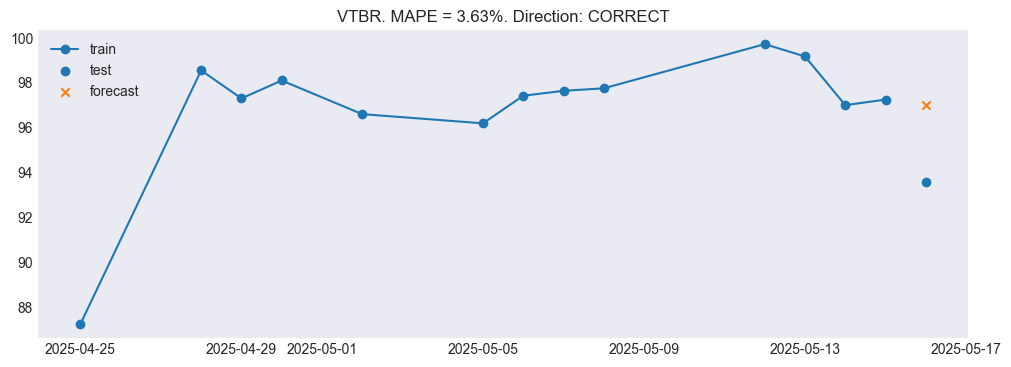

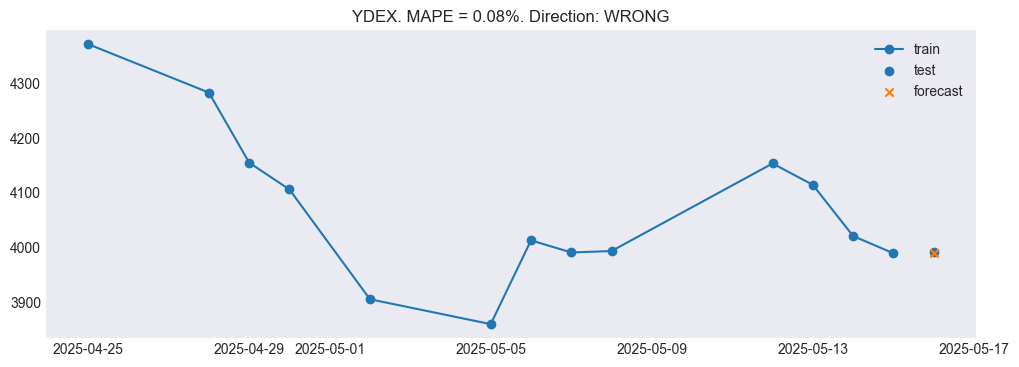

### Метрики

In [ ]:
for ticker in df['SECID'].unique():
    plt.figure(figsize=(12, 4))
    
    row_ticker = concatted_mlf[(concatted_mlf['unique_id'] == ticker) & (concatted_mlf['ds'] >= concatted_mlf['ds'].max() + pd.Timedelta(days=-20))]
    row_forecasts = forecasts[forecasts['unique_id'] == ticker]
    row_test = df[(df['TRADEDATE'] == df['TRADEDATE'].max()) & (df['SECID'] == ticker)]

    forecast_point = row_forecasts['TimesNet'].values[0]
    test_point = row_test['CLOSE'].values[0]
    train_last_point = row_ticker['y'].values[-1]

    mape_err = (np.abs(row_forecasts['TimesNet'].values - row_test['CLOSE'].values) / row_test['CLOSE'].values)[0]
    direction_correct_flg = ( (forecast_point > train_last_point) == (test_point > train_last_point) )

    plt.title(f'{ticker}. MAPE = {mape_err:.2%}. Direction: {"CORRECT" if direction_correct_flg == 1 else "WRONG"}')
    plt.plot(row_ticker['ds'], row_ticker['y'], label='train', marker='o')
    plt.scatter(row_forecasts['ds'], row_test['CLOSE'], label='test')
    plt.scatter(row_forecasts['ds'], row_forecasts['TimesNet'], marker='x', label='forecast')

    plt.grid()
    plt.legend()

In [957]:
last_train = concatted_mlf.loc[concatted_mlf['ds'] == concatted_mlf['ds'].max(), ['unique_id', 'y']].sort_values(by='unique_id')
forecast_test = forecasts.loc[:, ['unique_id', 'TimesNet']].sort_values(by='unique_id')
true_test = df.loc[(df['TRADEDATE'] == df['TRADEDATE'].max()), ['SECID', 'CLOSE']].sort_values(by='SECID')

avg_percentage_error = (np.abs(forecast_test['TimesNet'].values - true_test['CLOSE'].values) / np.abs(true_test['CLOSE'].values))
avg_percentage_error_mean = avg_percentage_error.mean()

directional_accuracy = ( (forecast_test['TimesNet'].values >= last_train['y'].values) == (true_test['CLOSE'].values >= last_train['y'].values) )
directional_accuracy_mean = directional_accuracy.mean()

by_share_table = pd.concat([forecast_test['unique_id'], 
                            pd.Series(avg_percentage_error * 100, name='MAPE').round(2).astype(str) + '%', 
                            pd.Series(directional_accuracy.astype(int), name='Guessed direction correctly?')],
                            axis=1)

avg_stats = pd.DataFrame({'MAPE': f'{avg_percentage_error_mean :.2%}',
                          'Directional_Accuracy': f'{directional_accuracy_mean :.2%}'},
                          index=['TimesNet'])

print(f'На данных {df["TRADEDATE"].max().date()} модель имеет следующие метрики качества предсказания:\n')
print('В разрезе по акциям:')
display(by_share_table)
print('\nВ среднем:')
display(avg_stats)

На данных 2025-05-16 модель имеет следующие метрики качества предсказания:

В разрезе по акциям:


unique_id     MAPE  Guessed direction correctly?
0       AFKS    0.34%                             1
1       AFLT    1.03%                             1
2       ALRS    0.52%                             1
3       BSPB    1.96%                             0
4       CBOM    1.83%                             1
5       CHMF    0.36%                             1
6       ENPG    0.81%                             1
7       FEES  273.81%                             0
8       FLOT    0.78%                             1
9       GAZP    0.06%                             1
10      GMKN    0.31%                             0
11      HYDR   41.64%                             1
12      IRAO    6.49%                             0
13      LKOH     0.1%                             1
14      MAGN    0.08%                             1
15      MGNT    1.18%                             1
16      MOEX    1.18%                             1
17      MSNG    7.65%                             1
18      MTLR    0.17%                             1
19     MTLRP    0.07%                             1
20      MTSS    0.92%                             1
21      NLMK    0.08%                             1
22      NVTK    0.14%                             0
23      PHOR    4.13%                             0
24      PIKK    2.84%                             1
25      PLZL    1.26%                             1
26      POSI    0.09%                             0
27      ROSN    0.46%                             1
28      RTKM    0.02%                             1
29      RUAL    0.82%                             1
30      SBER    0.61%                             0
31     SBERP    0.64%                             0
32      SELG    0.74%                             1
33      SMLT    0.77%                             1
34      SNGS    0.71%                             1
35     SNGSP    0.45%                             1
36         T    0.94%                             1
37      TATN    0.51%                             0
38     TATNP    0.58%                             0
39     TRNFP    0.41%                             1
40      UPRO   11.45%                             0
41      VKCO    0.49%                             0
42      VTBR     0.2%                             1
43      YDEX    0.81%                             0


В среднем:


MAPE Directional_Accuracy
TimesNet  8.42%               68.18%

In [992]:
concatted_mlf

unique_id         ds         y  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49         AFKS 2022-06-16    12.695      12.461      12.550      12.450   
50         AFKS 2022-06-17    12.508      12.695      12.461      12.550   
51         AFKS 2022-06-20    12.830      12.508      12.695      12.461   
52         AFKS 2022-06-21    12.972      12.830      12.508      12.695   
53         AFKS 2022-06-22    12.900      12.972      12.830      12.508   
...         ...        ...       ...         ...         ...         ...   
34093      YDEX 2025-05-08  3993.500    3991.000    4013.000    3860.000   
34094      YDEX 2025-05-12  4153.500    3993.500    3991.000    4013.000   
34095      YDEX 2025-05-13  4114.500    4153.500    3993.500    3991.000   
34096      YDEX 2025-05-14  4021.000    4114.500    4153.500    3993.500   
34097      YDEX 2025-05-15  3989.500    4021.000    4114.500    4153.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
34093    3905.500    4106.000    4155.000    4283.000  ...   
34094    3860.000    3905.500    4106.000    4155.000  ...   
34095    4013.000    3860.000    3905.500    4106.000  ...   
34096    3991.000    4013.000    3860.000    3905.500  ...   
34097    3993.500    3991.000    4013.000    3860.000  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
34093             4158.3750           4334.31000      4448.335838   
34094             4162.8250           4329.84000      4449.600744   
34095             4159.7500           4323.67000      4447.212780   
34096             4154.8250           4317.14000      4448.191882   
34097             4144.6500           4305.21000      4446.021880   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
34093      3868.414162  30.449534  31.410800  161.516957  31.191523   
34094      3876.049256  57.591179  39.355386  164.015746  30.042667   
34095      3872.287220  50.975403  46.338705  160.014621  28.975872   
34096      3861.458118  36.443662  48.336748  158.085005  28.348586   
34097      3843.278120  31.339286  39.586117  156.543219  28.383813   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
34093  -69.550466 -89.463001  
34094  -42.408821 -31.134743  
34095  -49.024597 -23.471627  
34096  -63.556338 -52.520816  
34097  -68.660714 -84.567274  

[32692 rows x 33 columns]

In [994]:
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
49    2022-06-16  AFKS    12.601    12.510    12.695    12.441    12.748   
50    2022-06-17  AFKS    12.611    12.700    12.508    12.508    12.741   
51    2022-06-20  AFKS    12.833    12.549    12.830    12.522    13.000   
52    2022-06-21  AFKS    12.904    12.990    12.972    12.760    12.990   
53    2022-06-22  AFKS    12.767    12.975    12.900    12.620    13.071   
...          ...   ...       ...       ...       ...       ...       ...   
35195 2025-05-21  YDEX  4009.000  4042.000  3990.500  3971.000  4050.000   
35196 2025-05-22  YDEX  3997.500  3980.500  4024.000  3925.000  4089.000   
35197 2025-05-23  YDEX  4016.500  4029.500  4009.500  3996.000  4048.000   
35198 2025-05-26  YDEX  3934.000  4004.000  3917.000  3886.000  4024.000   
35199 2025-05-27  YDEX  3969.500  3917.000  3992.500  3855.000  4024.000   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_short  \
49     24067400.0      12.461      12.550  ...               12.7172   
50      9084900.0      12.695      12.461  ...               12.6751   
51     35341000.0      12.508      12.695  ...               12.6786   
52     23216000.0      12.830      12.508  ...               12.7066   
53     23391800.0      12.972      12.830  ...               12.7216   
...           ...         ...         ...  ...                   ...   
35195    308142.0    4040.500    4054.000  ...             4100.2250   
35196    773529.0    3990.500    4040.500  ...             4083.3000   
35197    335528.0    4024.000    3990.500  ...             4069.5250   
35198    505249.0    4009.500    4024.000  ...             4050.7250   
35199    694981.0    3917.000    4009.500  ...             4031.7750   

       moving_average_long  bollinger_upper  bollinger_lower    stoch_k  \
49                12.76714        13.241743        12.192657  55.405405   
50                12.73950        13.118633        12.231567  38.558559   
51                12.71400        13.125847        12.231353  67.567568   
52                12.70442        13.153697        12.259503  80.360360   
53                12.69256        13.173489        12.269711  73.873874   
...                    ...              ...              ...        ...   
35195           4264.83000      4390.782477      3809.667523  44.458438   
35196           4254.02000      4349.161317      3817.438683  55.851064   
35197           4243.63000      4320.275768      3818.774232  51.994681   
35198           4232.37000      4287.635843      3813.814157  26.809651   
35199           4221.68000      4218.293223      3845.256777  41.044776   

         stoch_d         atr        adx  williams_r        cci  
49     44.024024    0.469477  14.103937  -44.594595 -27.967641  
50     42.762763    0.452586  14.087248  -61.441441 -35.663787  
51     53.843844    0.455401  14.721709  -32.432432  44.520739  
52     62.162162    0.439301  15.310852  -19.639640  83.163072  
53     73.933934    0.440136  15.312309  -26.126126  60.583060  
...          ...         ...        ...         ...        ...  
35195  44.550237  142.320502  27.381767  -55.541562 -59.682512  
35196  48.461376  143.869037  27.610998  -44.148936 -49.657297  
35197  50.768061  137.306963  27.823856  -48.005319 -41.886977  
35198  44.885132  137.356466  28.727334  -73.190349 -92.615381  
35199  39.949703  139.616718  29.742388  -58.955224 -78.458925  

[33044 rows x 38 columns]

In [995]:
dct_for_dates

{Timestamp('2022-06-16 00:00:00'): Timestamp('2022-06-16 00:00:00'),
 Timestamp('2022-06-17 00:00:00'): Timestamp('2022-06-17 00:00:00'),
 Timestamp('2022-06-18 00:00:00'): Timestamp('2022-06-20 00:00:00'),
 Timestamp('2022-06-19 00:00:00'): Timestamp('2022-06-21 00:00:00'),
 Timestamp('2022-06-20 00:00:00'): Timestamp('2022-06-22 00:00:00'),
 Timestamp('2022-06-21 00:00:00'): Timestamp('2022-06-23 00:00:00'),
 Timestamp('2022-06-22 00:00:00'): Timestamp('2022-06-24 00:00:00'),
 Timestamp('2022-06-23 00:00:00'): Timestamp('2022-06-27 00:00:00'),
 Timestamp('2022-06-24 00:00:00'): Timestamp('2022-06-28 00:00:00'),
 Timestamp('2022-06-25 00:00:00'): Timestamp('2022-06-29 00:00:00'),
 Timestamp('2022-06-26 00:00:00'): Timestamp('2022-06-30 00:00:00'),
 Timestamp('2022-06-27 00:00:00'): Timestamp('2022-07-01 00:00:00'),
 Timestamp('2022-06-28 00:00:00'): Timestamp('2022-07-04 00:00:00'),
 Timestamp('2022-06-29 00:00:00'): Timestamp('2022-07-05 00:00:00'),
 Timestamp('2022-06-30 00:00:00'):